In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/code2que-data/Code2Que-data/csharpdata/src-train.txt
/kaggle/input/code2que-data/Code2Que-data/csharpdata/reference.txt
/kaggle/input/code2que-data/Code2Que-data/csharpdata/hypothesis.txt
/kaggle/input/code2que-data/Code2Que-data/csharpdata/src-test-clear.txt
/kaggle/input/code2que-data/Code2Que-data/csharpdata/tgt-train.txt
/kaggle/input/code2que-data/Code2Que-data/csharpdata/tgt-test-clear.txt
/kaggle/input/code2que-data/Code2Que-data/jsdata/src-train.txt
/kaggle/input/code2que-data/Code2Que-data/jsdata/reference.txt
/kaggle/input/code2que-data/Code2Que-data/jsdata/hypothesis.txt
/kaggle/input/code2que-data/Code2Que-data/jsdata/src-test-clear.txt
/kaggle/input/code2que-data/Code2Que-data/jsdata/tgt-train.txt
/kaggle/input/code2que-data/Code2Que-data/jsdata/tgt-test-clear.txt
/kaggle/input/code2que-data/Code2Que-data/sqldata/src-train.txt
/kaggle/input/code2que-data/Code2Que-data/sqldata/reference.txt
/kaggle/input/code2que-data/Code2Que-data/sqldata/hypothesis.txt
/kagg

# Import library

In [2]:
import os
import sys
import time
import argparse
import shutil
from os import makedirs
from os.path import exists
import re
import string
import struct
from copy import deepcopy
import copy
import random
from random import shuffle

import numpy as np
from numpy.random import random as rand
import math

import pickle

import torch
import torch as T
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import operator  

# Configs Parameters

- CommonConfigs: Set đường dẫn tới data, model, kết quả,... dựa trên thư mục hiện tại -> chỉ cần đưa tên loại dữ liệu (d_type như "so") là nó auto build hết các path chuẩn.

- DeepmindTraining: Cấu hình trong giai đoạn training -> Unicode không bật, batch size là 32, có nhãn Y

- DeepmindTesting: Cấu hình trong giai đoạn testing -> Batch size lớn hơn (100), đặt độ dài min/max output, số lượng mẫu in ra, v.v.

- DeepmindConfigs: Cấu hình training tổng thể cho mô hình DeepMind -> Chọn cell là GRU, dùng Copy, Beam Search, Coverage, 2 chiều (bi-RNN), Hidden size = 256, Embedding size = 100, học rate 0.15, v.v.

- SOConfigs: Giống DeepmindConfigs nhưng cho bộ dữ liệu "so" -> Khác biệt chủ yếu là size từ điển (Pointer-Generator dictionary size) là 50k thay vì 60k.

In [3]:

class CommonConfigs(object):
    def __init__(self, d_type):
        self.ROOT_PATH = os.getcwd() + "/"  # Lấy đường dẫn thư mục hiện tại
        self.TRAINING_DATA_PATH = self.ROOT_PATH + d_type + "/train_set/"  # Đường dẫn tập huấn luyện
        self.VALIDATE_DATA_PATH = self.ROOT_PATH + d_type + "/validate_set/"  # Đường dẫn tập validation
        self.TESTING_DATA_PATH = self.ROOT_PATH + d_type + "/test_set/"  # Đường dẫn tập kiểm tra
        self.RESULT_PATH = self.ROOT_PATH + d_type + "/result/"  # Đường dẫn thư mục lưu kết quả
        self.MODEL_PATH = self.ROOT_PATH + d_type + "/model/"  # Đường dẫn thư mục lưu mô hình
        self.BEAM_SUMM_PATH = self.RESULT_PATH + "/beam_summary/"  # Đường dẫn lưu kết quả beam search
        self.BEAM_GT_PATH = self.RESULT_PATH + "/beam_ground_truth/"  # Đường dẫn lưu ground truth beam search
        self.GROUND_TRUTH_PATH = self.RESULT_PATH + "/ground_truth/"  # Đường dẫn ground truth
        self.SUMM_PATH = self.RESULT_PATH + "/summary/"  # Đường dẫn lưu tóm tắt
        self.TMP_PATH = self.ROOT_PATH + d_type + "/tmp/"  # Đường dẫn thư mục tạm

class DeepmindTraining(object):
    IS_UNICODE = False  # Setup sử dụng Unicode không
    REMOVES_PUNCTION = False  # Loại bỏ dấu câu hay không
    HAS_Y = True  # Có nhãn Y hay không
    BATCH_SIZE = 32  # Kích thước batch

class DeepmindTesting(object):
    IS_UNICODE = False  # Setup sử dụng Unicode không
    HAS_Y = True  # Có nhãn Y hay không
    BATCH_SIZE = 100  # Kích thước batch
    MIN_LEN_PREDICT = 35  # Độ dài tối thiểu của đầu ra dự đoán
    MAX_LEN_PREDICT = 120  # Độ dài tối đa của đầu ra dự đoán
    MAX_BYTE_PREDICT = None  # Giới hạn số byte đầu ra (None là không giới hạn)
    PRINT_SIZE = 500  # Số lượng mẫu hiển thị khi in kết quả
    REMOVES_PUNCTION = False  # Loại bỏ dấu câu hay không

class DeepmindConfigs():
    cc = CommonConfigs("so")  # Cấu hình chung cho tập dữ liệu "so"

    CELL = "gru"  # Loại cell RNN sử dụng (GRU hoặc LSTM)
    CUDA = True  # Sử dụng GPU hay không
    COPY = True  # Sử dụng cơ chế Copy hay không
    COVERAGE = True  # Sử dụng cơ chế Coverage hay không
    BI_RNN = True  # Sử dụng RNN hai chiều hay không
    BEAM_SEARCH = True  # Sử dụng Beam Search hay không
    BEAM_SIZE = 4  # Kích thước Beam Search
    AVG_NLL = False  # Sử dụng trung bình Negative Log-Likelihood hay không
    NORM_CLIP = 2  # Giới hạn giá trị norm của gradient
    if not AVG_NLL:
        NORM_CLIP = 5  # Nếu không dùng trung bình NLL thì đặt giá trị norm_clip là 5
    LR = 0.15  # Learning rate

    DIM_X = 100  # Số chiều embedding đầu vào
    DIM_Y = DIM_X  # Số chiều embedding đầu ra

    MIN_LEN_X = 16  # Độ dài tối thiểu của đầu vào
    MIN_LEN_Y = 4  # Độ dài tối thiểu của đầu ra
    MAX_LEN_X = 128  # Độ dài tối đa của đầu vào
    MAX_LEN_Y = 64  # Độ dài tối đa của đầu ra
    MIN_NUM_X = 1  # Số lượng tối thiểu của đầu vào
    MAX_NUM_X = 1  # Số lượng tối đa của đầu vào
    MAX_NUM_Y = None  # Số lượng tối đa của đầu ra (None là không giới hạn)

    NUM_Y = 1  # Số lượng đầu ra
    HIDDEN_SIZE = 256  # Kích thước hidden state của RNN

    UNI_LOW_FREQ_THRESHOLD = 10  # Ngưỡng tần suất thấp cho từ vựng

    PG_DICT_SIZE = 60000  # Kích thước từ điển của Pointer-Generator

    W_UNK = "<unk>"  # Token unknown
    W_BOS = "<bos>"  # Token bắt đầu câu
    W_EOS = "<eos>"  # Token kết thúc câu
    W_PAD = "<pad>"  # Token padding
    W_LS = "<s>"  # Token bắt đầu câu (có thể dùng riêng)
    W_RS = "</s>"  # Token kết thúc câu (có thể dùng riêng)

class SOConfigs():
    cc = CommonConfigs("so")  # Cấu hình chung cho tập dữ liệu "so"

    CELL = "gru"  # Loại cell RNN sử dụng (GRU hoặc LSTM)
    CUDA = True  # Sử dụng GPU hay không
    COPY = True  # Sử dụng cơ chế Copy hay không
    COVERAGE = True  # Sử dụng cơ chế Coverage hay không
    BI_RNN = True  # Sử dụng RNN hai chiều hay không
    BEAM_SEARCH = True  # Sử dụng Beam Search hay không
    BEAM_SIZE = 5  # Kích thước Beam Search
    AVG_NLL = False  # Sử dụng trung bình Negative Log-Likelihood hay không
    NORM_CLIP = 2  # Giới hạn giá trị norm của gradient
    if not AVG_NLL:
        NORM_CLIP = 5  # Nếu không dùng trung bình NLL thì đặt giá trị norm_clip là 5
    LR = 0.15  # Learning rate

    DIM_X = 100  # Số chiều embedding đầu vào
    DIM_Y = DIM_X  # Số chiều embedding đầu ra

    MIN_LEN_X = 16  # Độ dài tối thiểu của đầu vào
    MIN_LEN_Y = 4  # Độ dài tối thiểu của đầu ra
    MAX_LEN_X = 128  # Độ dài tối đa của đầu vào
    MAX_LEN_Y = 64  # Độ dài tối đa của đầu ra
    MIN_NUM_X = 1  # Số lượng tối thiểu của đầu vào
    MAX_NUM_X = 1  # Số lượng tối đa của đầu vào
    MAX_NUM_Y = None  # Số lượng tối đa của đầu ra (None là không giới hạn)

    NUM_Y = 1  # Số lượng đầu ra
    HIDDEN_SIZE = 256  # Kích thước hidden state của RNN

    UNI_LOW_FREQ_THRESHOLD = 10  # Ngưỡng tần suất thấp cho từ vựng

    PG_DICT_SIZE = 50000  # Kích thước từ điển của Pointer-Generator

    W_UNK = "<unk>"  # Token unknown
    W_BOS = "<bos>"  # Token bắt đầu câu
    W_EOS = "<eos>"  # Token kết thúc câu
    W_PAD = "<pad>"  # Token padding
    W_LS = "<s>"  # Token bắt đầu câu (có thể dùng riêng)
    W_RS = "</s>"  # Token kết thúc câu (có thể dùng riêng)


# Prepare Data

- Đọc file văn bản gốc (src) và file tóm tắt (tgt).
- Tách từ từng câu, biến thành từng list các từ.
- Gộp lại thành từ điển: Đếm xem từ nào xuất hiện bao nhiêu lần. Chỉ giữ lại top 50,000 từ xuất hiện nhiều nhất thôi (để mô hình đỡ nổ RAM).
- Xử lý từng câu: Biến mỗi đoạn thành list từ.Thêm token <eos> ở cuối để biết câu kết thúc chỗ nào.Đóng gói dữ liệu:Lưu các cặp (đoạn văn, tóm tắt) thành file .pkl.Lưu cả từ điển (word2index, index2word, v.v.) thành file .pkl.

- Mục tiêu:
=> Khi training mô hình thì chỉ cần mở file .pkl ra dùng ngay, cực nhanh, không phải mất công load và xử lý lại từng dòng văn bản!

In [4]:
stop_words = {"-lrb-", "-rrb-", "-"}
unk_words = {"unk", "<unk>"}

def load_vocab(src_path, tgt_path):
    """
    Đọc từ vựng từ file nguồn và file đích, tạo một từ điển đếm số lần xuất hiện của từng từ.
    """
    vocab_dict = {}
    vocab_list = []
    with open(src_path, 'r') as src:
        for line in src:
            words = line.lower().split()
            for word in words:
                if word not in vocab_dict:
                    vocab_dict[word] = 1
                    vocab_list.append(word)
                else: 
                    vocab_dict[word] += 1

    with open(tgt_path, 'r') as src:
        for line in src:
            words = line.lower().split()
            for word in words:
                if word not in vocab_dict:
                    vocab_dict[word] = 1
                    vocab_list.append(word)
                else: 
                    vocab_dict[word] += 1
    return vocab_dict, vocab_list
    pass

def to_dict(xys, dic):
    # Tập từ điển không bao gồm tập kiếm tra (dict should not consider test set)!!!!!
    """
    Cập nhật từ điển từ vựng với dữ liệu từ tập huấn luyện.
    """
    for xy in xys:
        sents, summs = xy
        y = summs[0]
        for w in y:
            if w in dic:
                dic[w] += 1
            else:
                dic[w] = 1
                
        x = sents[0]
        for w in x:
            if w in dic:
                dic[w] += 1
            else:
                dic[w] = 1
    return dic

def prepare_dict(src_path, tgt_path, train_xy_list, configs):
    """
    Xây dựng từ điển từ vựng với giới hạn số lượng từ nhất định.
    """
    print ("fitering and building dict...")
    use_abisee = True
    all_dic1 = {}
    all_dic2 = {}
    dic_list = []
    all_dic1, dic_list = load_vocab(src_path, tgt_path)
    all_dic2 = to_dict(train_xy_list, all_dic2)
    for w, tf in all_dic2.items():
        if w not in all_dic1:
            all_dic1[w] = tf

    candiate_list = dic_list[0:configs.PG_DICT_SIZE] # 50000
    candiate_set = set(candiate_list)

    dic = {}
    w2i = {}
    i2w = {}
    w2w = {}

    for w in [configs.W_PAD, configs.W_UNK, configs.W_EOS]:
        w2i[w] = len(dic)
        i2w[w2i[w]] = w
        dic[w] = 10000
        w2w[w] = w

    for w, tf in all_dic1.items():
        if w in candiate_set:
            w2i[w] = len(dic)
            i2w[w2i[w]] = w
            dic[w] = tf
            w2w[w] = w
        else:
            w2w[w] = configs.W_UNK 

    hfw = []
    sorted_x = sorted(dic.items(), key=operator.itemgetter(1), reverse=True)
    for w in sorted_x:
        hfw.append(w[0])

    assert len(hfw) == len(dic)
    assert len(w2i) == len(dic)
    return all_dic1, dic, hfw, w2i, i2w, w2w
 

def get_xy_tuple(cont, head, configs):
    """
    Chuyển đổi nội dung từ câu thành tuple (đoạn văn bản gốc, câu tóm tắt).
    """
    x = read_cont(cont, configs)
    y = read_head(head, configs)

    if x != None and y != None:
        return (x, y)
    else:
        return None

def read_cont(src_line, cfg):
    """
    Xử lý văn bản nguồn (đoạn văn gốc) và thêm token kết thúc câu.
    """
    lines = []
    line = src_line #del_num(f_cont)
    words = line.split()
    lines += words
    lines += [cfg.W_EOS]
    return (lines, src_line) 

def read_head(tgt_line, cfg):
    """
    Xử lý tiêu đề hoặc câu tóm tắt với token kết thúc câu.
    """
    lines = []
    line = tgt_line 
    words = line.split()
    lines += words
    lines += [cfg.W_EOS]
    return (lines, tgt_line) 

def load_lines(src_path, tgt_path,  configs):
    """
    Đọc dữ liệu từ file nguồn và file đích, sau đó chuyển đổi thành danh sách tuple (input, summary).
    """
    lines = []
    with open(src_path, 'r') as src_file, open(tgt_path, 'r') as tgt_file:
        for src_line, tgt_line in zip(src_file, tgt_file):

            src_line = src_line.strip().lower()
            tgt_line = tgt_line.strip().lower()
            xy_tuple = get_xy_tuple(src_line, tgt_line, configs)
            lines.append(xy_tuple)
    return lines


def prepare_dir():
   return configs

def prepare_so_dataset():
    """
    Chuẩn bị và xử lý dữ liệu tập huấn luyện, kiểm thử, và validation.
    """
    # Prepare Dirs
    configs = DeepmindConfigs()
    TRAINING_PATH = configs.cc.TRAINING_DATA_PATH
    VALIDATE_PATH = configs.cc.VALIDATE_DATA_PATH
    TESTING_PATH = configs.cc.TESTING_DATA_PATH
    RESULT_PATH = configs.cc.RESULT_PATH
    MODEL_PATH = configs.cc.MODEL_PATH
    BEAM_SUMM_PATH = configs.cc.BEAM_SUMM_PATH
    BEAM_GT_PATH = configs.cc.BEAM_GT_PATH
    GROUND_TRUTH_PATH = configs.cc.GROUND_TRUTH_PATH
    SUMM_PATH = configs.cc.SUMM_PATH
    TMP_PATH = configs.cc.TMP_PATH

    print ("train: " + TRAINING_PATH)
    print ("test: " + TESTING_PATH)
    print ("validate: " + VALIDATE_PATH) 
    print ("result: " + RESULT_PATH)
    print ("model: " + MODEL_PATH)
    print ("tmp: " + TMP_PATH)

    if not exists(TRAINING_PATH):
        makedirs(TRAINING_PATH)
    if not exists(VALIDATE_PATH):
        makedirs(VALIDATE_PATH)
    if not exists(TESTING_PATH):
        makedirs(TESTING_PATH)
    if not exists(RESULT_PATH):
        makedirs(RESULT_PATH)
    if not exists(MODEL_PATH):
        makedirs(MODEL_PATH)
    if not exists(BEAM_SUMM_PATH):
        makedirs(BEAM_SUMM_PATH)
    if not exists(BEAM_GT_PATH):
        makedirs(BEAM_GT_PATH)
    if not exists(GROUND_TRUTH_PATH):
        makedirs(GROUND_TRUTH_PATH)
    if not exists(SUMM_PATH):
        makedirs(SUMM_PATH)
    if not exists(TMP_PATH):
        makedirs(TMP_PATH)

    data_dir = "/kaggle/input/code2que-data/Code2Que-data/csharpdata"
    # Prepare Dataset 
    src_path = f"{data_dir}/src-train.txt"
    tgt_path = f"{data_dir}/tgt-train.txt"
    print ("trainset...")
    train_xy_list = load_lines(src_path, tgt_path,  configs)
    print ("dump train...")
    pickle.dump(train_xy_list, open(TRAINING_PATH + "train.pkl", "wb"), protocol = pickle.HIGHEST_PROTOCOL)
    
    all_dic1, dic, hfw, w2i, i2w, w2w = prepare_dict(src_path, tgt_path, train_xy_list, configs)
    print ("dump dict...")
    pickle.dump([all_dic1, dic, hfw, w2i, i2w, w2w], open(TRAINING_PATH + "dic.pkl", "wb"), protocol = pickle.HIGHEST_PROTOCOL)

    src_path = f"{data_dir}/src-test-clear.txt"
    tgt_path = f"{data_dir}/tgt-test-clear.txt"
    print ("valset...")
    val_xy_list = load_lines(src_path, tgt_path,  configs)
    print ("dump val...")
    pickle.dump(val_xy_list, open(VALIDATE_PATH + "./val.pkl", "wb"), protocol = pickle.HIGHEST_PROTOCOL)
    
    src_path = f"{data_dir}/src-test-clear.txt"
    tgt_path = f"{data_dir}/tgt-test-clear.txt"
    print ("testset...")
    test_xy_list = load_lines(src_path, tgt_path,  configs)
    print ("dump val...")
    pickle.dump(test_xy_list, open(TESTING_PATH + "./test.pkl", "wb"), protocol = pickle.HIGHEST_PROTOCOL)
    

if __name__ == "__main__":
    prepare_so_dataset()
    print("Finished")



train: /kaggle/working/so/train_set/
test: /kaggle/working/so/test_set/
validate: /kaggle/working/so/validate_set/
result: /kaggle/working/so/result/
model: /kaggle/working/so/model/
tmp: /kaggle/working/so/tmp/
trainset...
dump train...
fitering and building dict...
dump dict...
valset...
dump val...
testset...
dump val...
Finished


# Build model

## Utils PG

In [5]:
# Khởi tạo seed cho random và PyTorch để đảm bảo tái lập kết quả
def init_seeds():
    random.seed(123)
    torch.manual_seed(123)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(123)

# Khởi tạo trọng số cho LSTM
def init_lstm_weight(lstm):
    for param in lstm.parameters():
        if len(param.shape) >= 2: # weights
            init_ortho_weight(param.data)
        else: # bias
            init_bias(param.data)

# Khởi tạo trọng số cho GRU
def init_gru_weight(gru):
    for param in gru.parameters():
        if len(param.shape) >= 2: # weights
            init_ortho_weight(param.data)
        else: # bias
            init_bias(param.data)

# Khởi tạo trọng số cho lớp tuyến tính
def init_linear_weight(linear):
    init_xavier_weight(linear.weight)
    if linear.bias is not None:
        init_bias(linear.bias)

# Khởi tạo trọng số theo phân phối chuẩn
def init_normal_weight(w):
    nn.init.normal_(w, mean=0, std=0.01)

# Khởi tạo trọng số theo phân phối đều
def init_uniform_weight(w):
    nn.init.uniform_(w, -0.1, 0.1)

# Khởi tạo trọng số theo phương pháp trực giao
def init_ortho_weight(w):
    nn.init.orthogonal_(w)

# Khởi tạo trọng số theo phương pháp Xavier
def init_xavier_weight(w):
    nn.init.xavier_normal_(w)

# Khởi tạo bias với giá trị 0
def init_bias(b):
    nn.init.constant_(b, 0.)

# Xóa và tạo lại thư mục
def rebuild_dir(path):
    if os.path.exists(path):
        try:
            shutil.rmtree(path)
        except OSError:
            pass
    os.mkdir(path)

    
# Lưu trạng thái mô hình và optimizer
def save_model(f, model, optimizer):
    torch.save({"model_state_dict" : model.state_dict(),
            "optimizer_state_dict" : optimizer.state_dict()},
            f)

# Tải trạng thái mô hình và optimizer
def load_model(f, model, optimizer):
    checkpoint = torch.load(f)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    return model, optimizer

# Sắp xếp các mẫu theo độ dài của chúng
def sort_samples(x, len_x, mask_x, y, len_y, \
                 mask_y, oys, x_ext, y_ext, oovs):
    sorted_x_idx = np.argsort(len_x)[::-1]
    
    sorted_x_len = np.array(len_x)[sorted_x_idx]
    sorted_x = x[:, sorted_x_idx]
    sorted_x_mask = mask_x[:, sorted_x_idx, :]
    sorted_oovs = [oovs[i] for i in sorted_x_idx]

    sorted_y_len = np.array(len_y)[sorted_x_idx]
    sorted_y = y[:, sorted_x_idx]
    sorted_y_mask = mask_y[:, sorted_x_idx, :]
    sorted_oys = [oys[i] for i in sorted_x_idx]
    sorted_x_ext = x_ext[:, sorted_x_idx]
    sorted_y_ext = y_ext[:, sorted_x_idx]
    
    return sorted_x, sorted_x_len, sorted_x_mask, sorted_y, \
           sorted_y_len, sorted_y_mask, sorted_oys, \
           sorted_x_ext, sorted_y_ext, sorted_oovs

# In ra các câu gốc và câu dự đoán
def print_sent_dec(y_pred, y, y_mask, oovs, modules, consts, options, batch_size):
    print("golden truth and prediction samples:")
    max_y_words = np.sum(y_mask, axis = 0)
    max_y_words = max_y_words.reshape((batch_size))
    max_num_docs = 16 if batch_size > 16 else batch_size
    is_unicode = options["is_unicode"]
    dict_size = len(modules["i2w"])
    for idx_doc in range(max_num_docs):
        print(idx_doc + 1, "----------------------------------------------------------------------------------------------------")
        sent_true= ""
        for idx_word in range(max_y_words[idx_doc]):
            i = y[idx_word, idx_doc] if options["has_learnable_w2v"] else np.argmax(y[idx_word, idx_doc]) 
            if i in modules["i2w"]:
                sent_true += modules["i2w"][i]
            else:
                sent_true += oovs[idx_doc][i - dict_size]
            if not is_unicode:
                sent_true += " "

        if is_unicode:
            print(sent_true.encode("utf-8"))
        else:
            print(sent_true)

        print()

        sent_pred = ""
        for idx_word in range(max_y_words[idx_doc]):
            i = torch.argmax(y_pred[idx_word, idx_doc, :]).item()
            if i in modules["i2w"]:
                sent_pred += modules["i2w"][i]
            else:
                sent_pred += oovs[idx_doc][i - dict_size]
            if not is_unicode:
                sent_pred += " "
        if is_unicode:
            print(sent_pred.encode("utf-8"))
        else:
            print(sent_pred)
    print("----------------------------------------------------------------------------------------------------")
    print()

# Ghi kết quả tóm tắt để đánh giá ROUGE
def write_for_rouge(fname, ref_sents, dec_words, cfg):
    dec_sents = []
    while len(dec_words) > 0:
        try:
            fst_period_idx = dec_words.index(".")
        except ValueError:
            fst_period_idx = len(dec_words)
        sent = dec_words[:fst_period_idx + 1]
        dec_words = dec_words[fst_period_idx + 1:]
        dec_sents.append(' '.join(sent))

    ref_file = "".join((cfg.cc.GROUND_TRUTH_PATH, fname))
    decoded_file = "".join((cfg.cc.SUMM_PATH, fname))

    with open(ref_file, "w") as f:
        for idx, sent in enumerate(ref_sents):
            sent = sent.strip()
            f.write(sent) if idx == len(ref_sents) - 1 else f.write(sent + "\n")
    with open(decoded_file, "w") as f:
        for idx, sent in enumerate(dec_sents):
            sent = sent.strip()
            f.write(sent) if idx == len(dec_sents) - 1 else f.write(sent + "\n")

# Ghi kết quả tóm tắt vào file
def write_summ(dst_path, summ_list, num_summ, options, i2w = None, oovs=None, score_list = None):
    assert num_summ > 0
    with open(dst_path, "w") as f_summ:
        if num_summ == 1:
            if score_list != None:
                f_summ.write(str(score_list[0]))
                f_summ.write("\t")
            if i2w != None:
                '''
                for e in summ_list:
                    e = int(e)
                    if e in i2w:
                        print i2w[e],
                    else:
                        print oovs[e - len(i2w)],
                print "\n"
                '''
                s = []
                for e in summ_list:
                    e = int(e)
                    if e in i2w:
                        s.append(i2w[e])
                    else:
                        s.append(oovs[e - len(i2w)])
                s = " ".join(s)
            else:
                s = " ".join(summ_list)
            f_summ.write(s)
            f_summ.write("\n")
        else:
            assert num_summ == len(summ_list)
            if score_list != None:
                assert num_summ == len(score_list)

            for i in range(num_summ):
                if score_list != None:
                    f_summ.write(str(score_list[i]))
                    f_summ.write("\t")
                if i2w != None:
                    '''
                    for e in summ_list[i]:
                        e = int(e)
                        if e in i2w:
                            print i2w[e],
                        else:
                            print oovs[e - len(i2w)],
                    print "\n"
                    '''
                    s = []
                    for e in summ_list[i]:
                        e = int(e)
                        if e in i2w:
                            s.append(i2w[e])
                        else:
                            s.append(oovs[e - len(i2w)])
                    s = " ".join(s)
                else:
                    s = " ".join(summ_list[i])

                f_summ.write(s)
                f_summ.write("\n")




## GRU Decoder

Decoder trong Seq-2-seq -> GRU + Attention + Copy Mechanism + Coverage Attention

In [6]:

class GRUAttentionDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, ctx_size, device, copy, coverage, is_predicting):
        super(GRUAttentionDecoder, self).__init__()
        
        # Kích thước của các tham số chính
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx_size = ctx_size
        self.is_predicting = is_predicting
        self.device = device
        self.copy = copy  # Cơ chế copy mechanism
        self.coverage = coverage  # Cơ chế coverage attention

        # Tham số cho cổng cập nhật và cổng xoá của GRU
        self.W = nn.Parameter(torch.Tensor(2 * self.hidden_size, self.input_size))
        self.U = nn.Parameter(torch.Tensor(2 * self.hidden_size, self.hidden_size))
        self.b = nn.Parameter(torch.Tensor(2 * self.hidden_size))
        
        # Tham số cho cổng đầu ra của GRU
        self.Wx = nn.Parameter(torch.Tensor(self.hidden_size, self.input_size))
        self.Ux = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.bx = nn.Parameter(torch.Tensor(self.hidden_size))

        # Tham số cho attention context vector
        self.Wc_att = nn.Parameter(torch.Tensor(self.ctx_size, self.ctx_size))
        self.b_att = nn.Parameter(torch.Tensor(self.ctx_size))

        # Tham số cho cơ chế tính attention score
        self.W_comb_att = nn.Parameter(torch.Tensor(self.ctx_size, self.hidden_size))
        self.U_att = nn.Parameter(torch.Tensor(1, self.ctx_size))
        
        # Tham số cho GRU trong kiến trúc attention
        self.U_nl = nn.Parameter(torch.Tensor(2 * self.hidden_size, self.hidden_size)) 
        self.b_nl = nn.Parameter(torch.Tensor(2 * self.hidden_size))

        self.Ux_nl = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.bx_nl = nn.Parameter(torch.Tensor(self.hidden_size))

        # Tham số để kết hợp hidden state với context vector
        self.Wc = nn.Parameter(torch.Tensor(2 * self.hidden_size, self.ctx_size))
        self.Wcx = nn.Parameter(torch.Tensor(self.hidden_size, self.ctx_size))

        # Nếu có coverage attention, thêm tham số cho cơ chế này
        if self.coverage:
            self.W_coverage = nn.Parameter(torch.Tensor(self.ctx_size, 1))

        # Khởi tạo trọng số
        self.init_weights()

    def init_weights(self):
        """Hàm khởi tạo trọng số của mô hình."""
        init_ortho_weight(self.W)
        init_ortho_weight(self.U)
        init_bias(self.b)
        init_ortho_weight(self.Wx)
        init_ortho_weight(self.Ux)
        init_bias(self.bx)
        init_ortho_weight(self.Wc_att)
        init_bias(self.b_att)
        init_ortho_weight(self.W_comb_att)
        init_ortho_weight(self.U_att)
        init_ortho_weight(self.U_nl)
        init_bias(self.b_nl)
        init_ortho_weight(self.Ux_nl)
        init_bias(self.bx_nl)
        init_ortho_weight(self.Wc)
        init_ortho_weight(self.Wcx)
        if self.coverage:
            init_ortho_weight(self.W_coverage)


    def forward(self, y_emb, context, init_state, x_mask, y_mask, xid=None, init_coverage=None):

        def _get_word_atten(pctx, h1, x_mask, acc_att=None): #acc_att: B * len(x)
            if acc_att is not None:
                h = F.linear(h1, self.W_comb_att) + F.linear(T.transpose(acc_att, 0, 1).unsqueeze(2), self.W_coverage) # len(x) * B * ?
            else:
                h = F.linear(h1, self.W_comb_att)
            unreg_att = T.tanh(pctx + h) * x_mask
            unreg_att = F.linear(unreg_att, self.U_att)

            word_atten = T.exp(unreg_att - T.max(unreg_att, 0, keepdim = True)[0]) * x_mask
            sum_word_atten = T.sum(word_atten, 0, keepdim = True)
            word_atten =  word_atten / sum_word_atten
            return word_atten

        def recurrence(x, xx, y_mask, pre_h, pctx, context, x_mask, acc_att=None):
            tmp1 = T.sigmoid(F.linear(pre_h, self.U) + x) 
            r1, u1 = tmp1.chunk(2, 1) 
            h1 = T.tanh(F.linear(pre_h * r1, self.Ux) + xx)
            h1 = u1 * pre_h + (1.0 - u1) * h1
            h1 = y_mask * h1 + (1.0 - y_mask) * pre_h

            # len(x) * batch_size * 1
            if self.coverage:
                word_atten = _get_word_atten(pctx, h1, x_mask, acc_att)
            else:
                word_atten = _get_word_atten(pctx, h1, x_mask)
            atted_ctx = T.sum(word_atten * context, 0)

            tmp2 = T.sigmoid(F.linear(atted_ctx, self.Wc) + F.linear(h1, self.U_nl) + self.b_nl)
            r2, u2 = tmp2.chunk(2, 1)  
            h2 = T.tanh(F.linear(atted_ctx, self.Wcx) + F.linear(h1 * r2, self.Ux_nl) + self.bx_nl)
            h2 = u2 * h1 + (1.0 - u2) * h2
            h2 = y_mask * h2 + (1.0 - y_mask) * h1

            word_atten_ = T.transpose(word_atten.view(x_mask.size(0), -1), 0, 1) # B * len(x)
            if self.coverage:
                acc_att += word_atten_
                return h2, h2, atted_ctx, word_atten_, acc_att
            else:
                return h2, h2, atted_ctx, word_atten_

        # Khởi tạo các danh sách để lưu trữ các giá trị qua từng bước thời gian
        hs, ss, atts, dists, xids, cs = [], [], [], [], [], []
        hidden = init_state # Hidden state ban đầu
        acc_att = init_coverage # Độ bao phủ attention nếu sử dụng coverage

         # Đảo chiều dữ liệu nếu có cơ chế copy
        if self.copy:
            xid = T.transpose(xid, 0, 1) # B * len(x)

        # Tính toán vector context đã qua một lớp biến đổi tuyến tính
        pctx = F.linear(context, self.Wc_att, self.b_att)
        x = F.linear(y_emb, self.W, self.b)
        xx = F.linear(y_emb, self.Wx, self.bx)

        # Lặp qua từng bước thời gian
        steps = range(y_emb.size(0))
        for i in steps:
            if self.coverage:
                cs += [acc_att]
                hidden, s, att, att_dist, acc_att = recurrence(x[i], xx[i], y_mask[i], hidden, pctx, context, x_mask, acc_att)
            else:
                hidden, s, att, att_dist = recurrence(x[i], xx[i], y_mask[i], hidden, pctx, context, x_mask)
            # Lưu trạng thái tại mỗi bước thời gian
            hs += [hidden]
            ss += [s]
            atts += [att]
            dists += [att_dist]
            xids += [xid]
        # Nếu có sử dụng coverage attention, cập nhật danh sách cs
        if self.coverage:
            if self.is_predicting :
                cs += [acc_att]
                cs = cs[1:]
            cs = T.stack(cs).view(y_emb.size(0), *cs[0].size())
            
        # Chuyển danh sách các tensor thành một tensor hoàn chỉnh
        hs = T.stack(hs).view(y_emb.size(0), *hs[0].size())
        ss = T.stack(ss).view(y_emb.size(0), *ss[0].size())
        atts = T.stack(atts).view(y_emb.size(0), *atts[0].size())
        dists = T.stack(dists).view(y_emb.size(0), *dists[0].size())
        if self.copy:
            xids = T.stack(xids).view(y_emb.size(0), *xids[0].size())
        
        # Trả về các giá trị phù hợp tùy vào việc có sử dụng copy hoặc coverage hay không
        if self.copy and self.coverage:
            return hs, ss, atts, dists, xids, cs
        elif self.copy:
            return hs, ss, atts, dists, xids
        elif self.coverage:
            return hs, ss, atts, dists, cs
        else:
            return hs, ss, atts

## LSTM Decoder

LSTMAttentionDecoder là Decoder trong mô hình Seq2Seq, dùng LSTM + Attention để sinh ra từng từ output.

Tưởng tượng đơn giản:
➔ Input vào 1 từ → LSTM xử lý → Attention chọn chỗ cần chú ý từ input → Sinh ra từ tiếp theo.
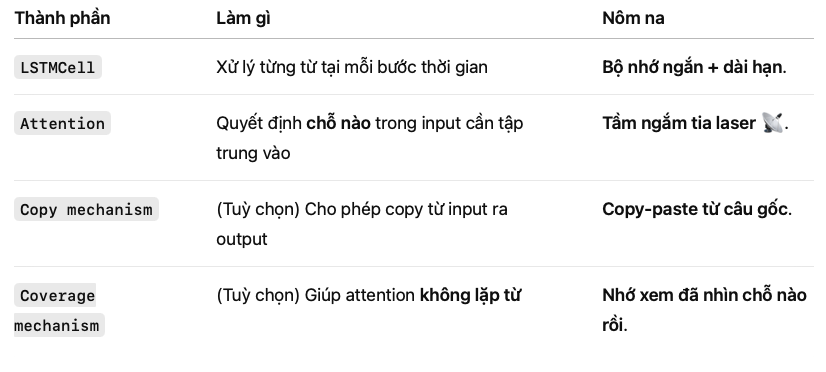

In [7]:
class LSTMAttentionDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, ctx_size, device, copy, coverage, is_predicting):
        super(LSTMAttentionDecoder, self).__init__()
        self.input_size = input_size  # Kích thước đầu vào của LSTM (embedding của từ)
        self.hidden_size = hidden_size  # Kích thước ẩn của LSTM
        self.ctx_size = ctx_size  # Kích thước vector ngữ cảnh (context vector)
        self.is_predicting = is_predicting  # Cờ báo đang trong giai đoạn dự đoán (inference)
        self.device = device  # Thiết bị tính toán (CPU hoặc GPU)
        self.copy = copy  # Cờ báo có sử dụng cơ chế copy (copy mechanism)
        self.coverage = coverage  # Cờ báo có sử dụng cơ chế coverage (coverage mechanism)
        
        self.lstm_1 = nn.LSTMCell(self.input_size, self.hidden_size)  # Lớp LSTMCell đầu tiên

        self.Wx = nn.Parameter(torch.Tensor(4 * self.hidden_size, self.ctx_size)) # Ma trận trọng số để biến đổi context vector.
        self.Ux = nn.Parameter(torch.Tensor(4 * self.hidden_size, self.hidden_size)) # Ma trận trọng số để biến đổi hidden state.
        self.bx = nn.Parameter(torch.Tensor(4 * self.hidden_size)) # Vector bias cho phép biến đổi.

        self.Wc_att = nn.Parameter(torch.Tensor(self.ctx_size, self.ctx_size))  # Ma trận trọng số cho việc tính toán attention trên context
        self.b_att = nn.Parameter(torch.Tensor(self.ctx_size))  # Vector bias cho việc tính toán attention trên context

        self.W_comb_att = nn.Parameter(torch.Tensor(self.ctx_size, 2*self.hidden_size)) # Ma trận trọng số kết hợp hidden state với context.
        self.U_att = nn.Parameter(torch.Tensor(1, self.ctx_size)) # Ma trận trọng số cuối cùng để tính điểm attention.

        if self.coverage:
            self.W_coverage= nn.Parameter(torch.Tensor(self.ctx_size, 1)) # Ma trận trọng số cho coverage vector.

        self.init_weights()  # Khởi tạo trọng số

    def init_weights(self):
        init_lstm_weight(self.lstm_1)  # Khởi tạo trọng số cho LSTMCell
        init_ortho_weight(self.Wx) # Khởi tạo trọng số trực giao cho Wx
        init_ortho_weight(self.Ux) # Khởi tạo trọng số trực giao cho Ux
        init_bias(self.bx) # Khởi tạo bias cho bx
        init_ortho_weight(self.Wc_att)  # Khởi tạo trọng số trực giao cho Wc_att
        init_bias(self.b_att)  # Khởi tạo bias cho b_att
        init_ortho_weight(self.W_comb_att)  # Khởi tạo trọng số trực giao cho W_comb_att
        init_ortho_weight(self.U_att)  # Khởi tạo trọng số trực giao cho U_att
        if self.coverage:
            init_ortho_weight(self.W_coverage)  # Khởi tạo trọng số trực giao cho W_coverage

    def forward(self, y_emb, context, init_state, x_mask, y_mask, xid=None, init_coverage=None):
        def _get_word_atten(pctx, h1, x_mask, acc_att=None): #acc_att: B * len(x)
            if acc_att is not None:
                h = F.linear(h1, self.W_comb_att) + F.linear(T.transpose(acc_att, 0, 1).unsqueeze(2), self.W_coverage) # len(x) * B * ?
            else:
                h = F.linear(h1, self.W_comb_att)
            unreg_att = T.tanh(pctx + h) * x_mask # Tính toán điểm attention chưa chuẩn hóa
            unreg_att = F.linear(unreg_att, self.U_att) # Áp dụng ma trận U_att

            word_atten = T.exp(unreg_att - T.max(unreg_att, 0, keepdim = True)[0]) * x_mask # Chuẩn hóa điểm attention bằng softmax
            sum_word_atten = T.sum(word_atten, 0, keepdim = True) # Tổng các điểm attention
            word_atten =  word_atten / sum_word_atten # Chuẩn hóa điểm attention
            return word_atten

        def recurrence(x, y_mask, hidden, pctx, context, x_mask, acc_att=None):
            pre_h, pre_c = hidden

            h1, c1 = self.lstm_1(x, hidden)  # Tính toán hidden state và cell state của LSTM
            h1 = y_mask * h1 + (1.0 - y_mask) * pre_h # Áp dụng mask cho hidden state
            c1 = y_mask * c1 + (1.0 - y_mask) * pre_c # Áp dụng mask cho cell state
            
            # len(x) * batch_size * 1
            s = T.cat((h1.view(-1, self.hidden_size), c1.view(-1, self.hidden_size)), 1) # Kết hợp hidden state và cell state

            if self.coverage:
                word_atten = _get_word_atten(pctx, s, x_mask, acc_att) # Tính toán attention với coverage
            else:
                word_atten = _get_word_atten(pctx, s, x_mask) # Tính toán attention

            atted_ctx = T.sum(word_atten * context, 0) # Tính toán context vector được attention

            ifoc_preact = F.linear(h1, self.Ux) + F.linear(atted_ctx, self.Wx, self.bx) # Tính toán input, forget, output, cell gate
            x4i, x4f, x4o, x4c = ifoc_preact.chunk(4, 1) # Chia thành 4 phần
            i = torch.sigmoid(x4i) # Tính input gate
            f = torch.sigmoid(x4f) # Tính forget gate
            o = torch.sigmoid(x4o) # Tính output gate
            c2 = f * c1 + i * torch.tanh(x4c) # Tính toán cell state mới
            h2 = o * torch.tanh(c2) # Tính toán hidden state mới
            c2 = y_mask * c2 + (1.0 - y_mask) * c1 # Áp dụng mask cho cell state
            h2 = y_mask * h2 + (1.0 - y_mask) * h1 # Áp dụng mask cho hidden state

            word_atten_ = T.transpose(word_atten.view(x_mask.size(0), -1), 0, 1) # Chuyển vị ma trận attention
            
            if self.coverage:
                acc_att += word_atten_ # Cập nhật coverage vector
                return (h2, c2), h2, atted_ctx, word_atten_, acc_att
            else:
                return (h2, c2), h2, atted_ctx, word_atten_

        hs, cs, ss, atts, dists, xids, Cs = [], [], [], [], [], [], []
        hidden = init_state # Khởi tạo hidden state
        acc_att = init_coverage # Khởi tạo coverage vector
        if self.copy: 
            xid = T.transpose(xid, 0, 1) # B * len(x)

        pctx = F.linear(context, self.Wc_att, self.b_att) # Tính toán pctx (projected context)
        x = y_emb # Lấy embedding của từ đầu vào
        
        steps = range(y_emb.size(0))  # Số bước giải mã, dựa trên độ dài chuỗi đầu vào y_emb.
        for i in steps:
            if self.coverage:
                Cs += [acc_att]  # Lưu trữ coverage vector hiện tại vào danh sách Cs.
                hidden, s, att, att_dist, acc_att = recurrence(x[i], y_mask[i], hidden, pctx, context, x_mask, acc_att)  # Gọi hàm recurrence để thực hiện một bước giải mã với cơ chế coverage.
            else:
                hidden, s, att, att_dist = recurrence(x[i], y_mask[i], hidden, pctx,context, x_mask) # Gọi hàm recurrence để thực hiện một bước giải mã mà không có coverage.
            hs += [hidden[0]]  # Lưu trữ hidden state của LSTM.
            cs += [hidden[1]]  # Lưu trữ cell state của LSTM.
            ss += [s]  # Lưu trữ hidden state sau khi kết hợp với context.
            atts += [att]  # Lưu trữ context vector được attention.
            dists += [att_dist]  # Lưu trữ phân phối attention.
            xids += [xid]  # Lưu trữ xid (cho cơ chế copy).

        if self.coverage:
            if self.is_predicting :
                Cs += [acc_att]  # Lưu trữ coverage vector cuối cùng trong quá trình dự đoán.
                Cs = Cs[1:]  # Loại bỏ coverage vector khởi tạo.
            Cs = T.stack(Cs).view(y_emb.size(0), *Cs[0].size())  # Stack các coverage vector thành một tensor.

        hs = T.stack(hs).view(y_emb.size(0), *hs[0].size())  # Stack các hidden state thành một tensor.
        cs = T.stack(cs).view(y_emb.size(0), *cs[0].size())  # Stack các cell state thành một tensor.
        ss = T.stack(ss).view(y_emb.size(0), *ss[0].size())  # Stack các hidden state sau khi kết hợp thành một tensor.
        atts = T.stack(atts).view(y_emb.size(0), *atts[0].size())  # Stack các context vector được attention thành một tensor.
        dists = T.stack(dists).view(y_emb.size(0), *dists[0].size())  # Stack các phân phối attention thành một tensor.
        if self.copy:
            xids = T.stack(xids).view(y_emb.size(0), *xids[0].size())  # Stack các xid thành một tensor.

        if self.copy and self.coverage:
            return (hs, cs), ss, atts, dists, xids, Cs  # Trả về kết quả khi có cả copy và coverage.
        elif self.copy:
            return (hs, cs), ss, atts, dists, xids  # Trả về kết quả khi chỉ có copy.
        elif self.coverage:
            return (hs, cs), ss, atts, dists, Cs  # Trả về kết quả khi chỉ có coverage.
        else:
            return (hs, cs), ss, atts  # Trả về kết quả khi không có copy và coverage.

## Word Probably Layer

WordProbLayer là lớp cuối của decoder,nó biến hidden state + context thành xác suất các từ trong từ điển để dự đoán từ tiếp theo.
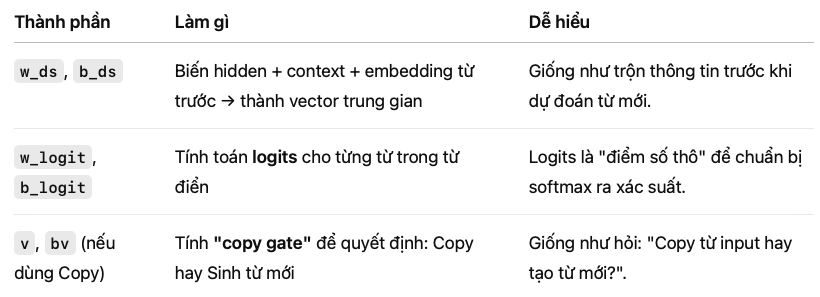


In [8]:
class WordProbLayer(nn.Module):
    def __init__(self, hidden_size, ctx_size, dim_y, dict_size, device, copy, coverage):
        super(WordProbLayer, self).__init__()
        self.hidden_size = hidden_size  # Kích thước hidden state của decoder.
        self.ctx_size = ctx_size  # Kích thước context vector.
        self.dim_y = dim_y  # Kích thước embedding của từ đầu ra.
        self.dict_size = dict_size  # Kích thước từ điển đầu ra.
        self.device = device  # Thiết bị (CPU/GPU) để tính toán.
        self.copy = copy  # Cờ báo có sử dụng cơ chế copy hay không.
        self.coverage = coverage  # Cờ báo có sử dụng cơ chế coverage hay không.

        self.w_ds = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size + self.ctx_size + self.dim_y))  # Ma trận trọng số để biến đổi hidden state, context vector và embedding đầu ra.
        self.b_ds = nn.Parameter(torch.Tensor(self.hidden_size))  # Vector bias cho phép biến đổi.
        self.w_logit = nn.Parameter(torch.Tensor(self.dict_size, self.hidden_size))  # Ma trận trọng số để tính logits của từ điển.
        self.b_logit = nn.Parameter(torch.Tensor(self.dict_size))  # Vector bias cho logits của từ điển.

        if self.copy:
            self.v = nn.Parameter(torch.Tensor(1, self.hidden_size + self.ctx_size + self.dim_y))  # Ma trận trọng số cho cơ chế copy.
            self.bv = nn.Parameter(torch.Tensor(1))  # Vector bias cho cơ chế copy.

        self.init_weights()  # Khởi tạo trọng số.

    def init_weights(self):
        init_xavier_weight(self.w_ds)  # Khởi tạo trọng số w_ds theo phương pháp Xavier.
        init_bias(self.b_ds)  # Khởi tạo bias b_ds.
        init_xavier_weight(self.w_logit)  # Khởi tạo trọng số w_logit theo phương pháp Xavier.
        init_bias(self.b_logit)  # Khởi tạo bias b_logit.
        if self.copy:
            init_xavier_weight(self.v)  # Khởi tạo trọng số v theo phương pháp Xavier.
            init_bias(self.bv)  # Khởi tạo bias bv.

    def forward(self, ds, ac, y_emb, att_dist=None, xids=None, max_ext_len=None):
        h = T.cat((ds, ac, y_emb), 2)  # Kết hợp hidden state, context vector và embedding đầu ra.
        logit = T.tanh(F.linear(h, self.w_ds, self.b_ds))  # Tính toán logits bằng cách áp dụng ma trận trọng số w_ds và bias b_ds, sau đó áp dụng hàm tanh.
        logit = F.linear(logit, self.w_logit, self.b_logit)  # Tính toán logits cuối cùng bằng cách áp dụng ma trận trọng số w_logit và bias b_logit.
        y_dec = T.softmax(logit, dim = 2)  # Tính toán phân phối xác suất của từ điển bằng hàm softmax.

        if self.copy:
            if max_ext_len > 0:
                ext_zeros = Variable(torch.zeros(y_dec.size(0), y_dec.size(1), max_ext_len)).to(self.device)  # Tạo tensor zero cho phần mở rộng của từ điển.
                y_dec = T.cat((y_dec, ext_zeros), 2)  # Kết hợp phân phối xác suất của từ điển với phần mở rộng.
            g = T.sigmoid(F.linear(h, self.v, self.bv))  # Tính toán gate g cho cơ chế copy bằng hàm sigmoid.
            y_dec = (g * y_dec).scatter_add(2, xids, (1 - g) * att_dist)  # Cập nhật phân phối xác suất bằng cách kết hợp phân phối từ điển và phân phối attention.

        return y_dec  # Trả về phân phối xác suất cuối cùng.

## Model

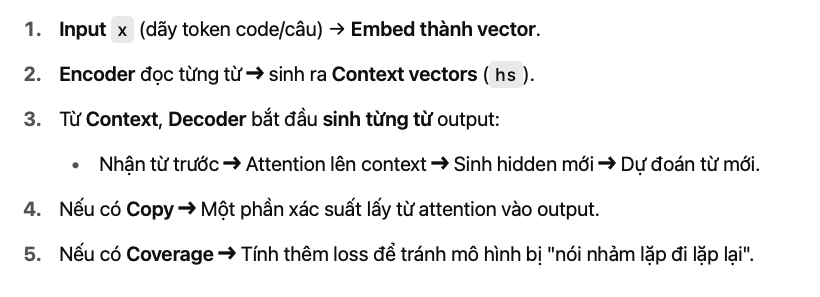

In [9]:
class Model(nn.Module):
    def __init__(self, modules, consts, options):
        super(Model, self).__init__()
        
        self.has_learnable_w2v = options["has_learnable_w2v"]  # Cờ báo có cho phép cập nhật embedding của từ hay không.
        self.is_predicting = options["is_predicting"]  # Cờ báo đang trong giai đoạn dự đoán (inference).
        self.is_bidirectional = options["is_bidirectional"]  # Cờ báo encoder có phải là bidirectional hay không.
        self.beam_decoding = options["beam_decoding"]  # Cờ báo có sử dụng beam search hay không.
        self.cell = options["cell"]  # Loại cell (GRU hoặc LSTM).
        self.device = options["device"]  # Thiết bị (CPU hoặc GPU).
        self.copy = options["copy"]  # Cờ báo có sử dụng cơ chế copy hay không.
        self.coverage = options["coverage"]  # Cờ báo có sử dụng cơ chế coverage hay không.
        self.avg_nll = options["avg_nll"]  # Cờ báo có tính trung bình loss NLL hay không.

        self.dim_x = consts["dim_x"]  # Kích thước embedding đầu vào.
        self.dim_y = consts["dim_y"]  # Kích thước embedding đầu ra.
        self.len_x = consts["len_x"]  # Độ dài tối đa của chuỗi đầu vào.
        self.len_y = consts["len_y"]  # Độ dài tối đa của chuỗi đầu ra.
        self.hidden_size = consts["hidden_size"]  # Kích thước hidden state.
        self.dict_size = consts["dict_size"]  # Kích thước từ điển.
        self.pad_token_idx = consts["pad_token_idx"]  # Index của token padding.
        self.ctx_size = self.hidden_size * 2 if self.is_bidirectional else self.hidden_size  # Kích thước context vector.

        self.w_rawdata_emb = nn.Embedding(self.dict_size, self.dim_x, self.pad_token_idx)  # Lớp embedding cho đầu vào.
        if self.cell == "gru":
            self.encoder = nn.GRU(self.dim_x, self.hidden_size, bidirectional=self.is_bidirectional)  # Encoder GRU.
            self.decoder = GRUAttentionDecoder(self.dim_y, self.hidden_size, self.ctx_size, self.device, self.copy, self.coverage, self.is_predicting)  # Decoder GRU with attention.
        else:
            self.encoder = nn.LSTM(self.dim_x, self.hidden_size, bidirectional=self.is_bidirectional)  # Encoder LSTM.
            self.decoder = LSTMAttentionDecoder(self.dim_y, self.hidden_size, self.ctx_size, self.device, self.copy, self.coverage, self.is_predicting)  # Decoder LSTM with attention.
            
        self.get_dec_init_state = nn.Linear(self.ctx_size, self.hidden_size)  # Lớp linear để khởi tạo hidden state của decoder.
        self.word_prob = WordProbLayer(self.hidden_size, self.ctx_size, self.dim_y, self.dict_size, self.device, self.copy, self.coverage)  # Lớp tính toán phân phối xác suất từ.

        self.init_weights()  # Khởi tạo trọng số.

    def init_weights(self):
        init_uniform_weight(self.w_rawdata_emb.weight)  # Khởi tạo trọng số của lớp embedding theo phân phối uniform.
        if self.cell == "gru":
            init_gru_weight(self.encoder)  # Khởi tạo trọng số của encoder GRU.
        else:
            init_lstm_weight(self.encoder)  # Khởi tạo trọng số của encoder LSTM.
        init_linear_weight(self.get_dec_init_state)  # Khởi tạo trọng số của lớp linear khởi tạo hidden state decoder.
    
    def nll_loss(self, y_pred, y, y_mask, avg=True):
        cost = -T.log(T.gather(y_pred, 2, y.view(y.size(0), y.size(1), 1)))  # Tính toán loss NLL.
        cost = cost.view(y.shape)  # Reshape cost.
        y_mask = y_mask.view(y.shape)  # Reshape mask.
        if avg:
            cost = T.sum(cost * y_mask, 0) / T.sum(y_mask, 0)  # Tính trung bình loss theo batch.
        else:
            cost = T.sum(cost * y_mask, 0)  # Tính tổng loss theo batch.
        cost = cost.view((y.size(1), -1))  # Reshape cost.
        return T.mean(cost)  # Tính trung bình loss trên toàn bộ batch.

    def encode(self, x, len_x, mask_x):
        self.encoder.flatten_parameters()  # Flatten parameters của encoder (để tối ưu hóa hiệu suất).
        emb_x = self.w_rawdata_emb(x)  # Embedding đầu vào.
        
        emb_x = torch.nn.utils.rnn.pack_padded_sequence(emb_x, len_x.cpu().to(torch.int64))  # Pack padded sequence.
        hs, hn = self.encoder(emb_x, None)  # Encode đầu vào.
        hs, _ = torch.nn.utils.rnn.pad_packed_sequence(hs)  # Pad packed sequence.
            
        dec_init_state = T.sum(hs * mask_x, 0) / T.sum(mask_x, 0)  # Tính hidden state khởi tạo của decoder.
        dec_init_state = T.tanh(self.get_dec_init_state(dec_init_state))  # Áp dụng hàm tanh.
        return hs, dec_init_state  # Trả về hidden states và hidden state khởi tạo của decoder.

    def decode_once(self, y, hs, dec_init_state, mask_x, x=None, max_ext_len=None, acc_att=None):
        batch_size = hs.size(1)  # Lấy batch size.
        if T.sum(y) < 0:
            y_emb = Variable(T.zeros((1, batch_size, self.dim_y))).to(self.device)  # Nếu y là âm, tạo embedding zero.
        else:
            y_emb = self.w_rawdata_emb(y)  # Embedding đầu vào.
        mask_y = Variable(T.ones((1, batch_size, 1))).to(self.device)  # Tạo mask cho đầu ra.

        if self.copy and self.coverage:
            hcs, dec_status, atted_context, att_dist, xids, C = self.decoder(y_emb, hs, dec_init_state, mask_x, mask_y, x, acc_att)  # Giải mã với copy và coverage.
        elif self.copy:
            hcs, dec_status, atted_context, att_dist, xids = self.decoder(y_emb, hs, dec_init_state, mask_x, mask_y, xid=x)  # Giải mã với copy.
        elif self.coverage:
            hcs, dec_status, atted_context, att_dist, C = self.decoder(y_emb, hs, dec_init_state, mask_x, mask_y, init_coverage=acc_att)  # Giải mã với coverage.
        else:
            hcs, dec_status, atted_context = self.decoder(y_emb, hs, dec_init_state, mask_x, mask_y)  # Giải mã thông thường.
        
        if self.copy:
            y_pred = self.word_prob(dec_status, atted_context, y_emb, att_dist, xids, max_ext_len)  # Tính toán phân phối xác suất từ với copy.
        else:
            y_pred = self.word_prob(dec_status, atted_context, y_emb)  # Tính toán phân phối xác suất từ.

        if self.coverage:
            return y_pred, hcs, C  # Trả về kết quả với coverage.
        else:
            return y_pred, hcs  # Trả về phân phối xác suất từ và hidden state của decoder.

    def forward(self, x, len_x, y, mask_x, mask_y, x_ext, y_ext, max_ext_len):
        
        hs, dec_init_state = self.encode(x, len_x, mask_x)  # Encode đầu vào.

        y_emb = self.w_rawdata_emb(y)  # Embedding đầu ra.
        y_shifted = y_emb[:-1, :, :]  # Shift đầu ra để tính toán loss.
        y_shifted = T.cat((Variable(torch.zeros(1, *y_shifted[0].size())).to(self.device), y_shifted), 0)  # Thêm embedding zero vào đầu.
        h0 = dec_init_state  # Khởi tạo hidden state của decoder.
        if self.cell == "lstm":
            h0 = (dec_init_state, dec_init_state)  # Nếu là LSTM, khởi tạo cả hidden state và cell state.
        if self.coverage:
            acc_att = Variable(torch.zeros(T.transpose(x, 0, 1).size())).to(self.device) # B * len(x) # Khởi tạo coverage vector.

        if self.copy and self.coverage:
            hcs, dec_status, atted_context, att_dist, xids, C = self.decoder(y_shifted, hs, h0, mask_x, mask_y, x_ext, acc_att)  # Giải mã với copy và coverage.
        elif self.copy:
            hcs, dec_status, atted_context, att_dist, xids = self.decoder(y_shifted, hs, h0, mask_x, mask_y, xid=x_ext)  # Giải mã với copy.
        elif self.coverage:
            hcs, dec_status, atted_context, att_dist, C = self.decoder(y_shifted, hs, h0, mask_x, mask_y, init_coverage=acc_att)  # Giải mã với coverage.
        else:
            hcs, dec_status, atted_context = self.decoder(y_shifted, hs, h0, mask_x, mask_y)  # Giải mã thông thường.
        
        if self.copy:
            y_pred = self.word_prob(dec_status, atted_context, y_shifted, att_dist, xids, max_ext_len)  # Tính toán phân phối xác suất từ với copy.
            cost = self.nll_loss(y_pred, y_ext, mask_y, self.avg_nll)  # Tính toán loss NLL với copy.
        else:
            y_pred = self.word_prob(dec_status, atted_context, y_shifted)  # Tính toán phân phối xác suất từ.
            cost = self.nll_loss(y_pred, y, mask_y, self.avg_nll)  # Tính toán loss NLL.
        
        if self.coverage:
            cost_c = T.mean(T.sum(T.min(att_dist, C), 2))  # Tính toán loss coverage.
            return y_pred, cost, cost_c  # Trả về phân phối xác suất từ, loss NLL và loss coverage.
        else:
            return y_pred, cost, None  # Trả về phân phối xác suất từ, loss NLL và None (nếu không có coverage).

# Main

## Building dataloader

In [10]:
class BatchData:
    def __init__(self, flist, modules, consts, options):
        self.batch_size = len(flist)  # Số lượng tài liệu trong batch.
        self.x = np.zeros((consts["len_x"], self.batch_size), dtype = np.int64)  # Mảng chứa ID từ của nội dung tài liệu (đầu vào).
        self.x_ext = np.zeros((consts["len_x"], self.batch_size), dtype = np.int64)  # Mảng chứa ID từ của nội dung tài liệu (đầu vào) với từ OOV.
        self.y = np.zeros((consts["len_y"], self.batch_size), dtype = np.int64)  # Mảng chứa ID từ của tóm tắt (đầu ra).
        self.y_ext = np.zeros((consts["len_y"], self.batch_size), dtype = np.int64)  # Mảng chứa ID từ của tóm tắt (đầu ra) với từ OOV.
        self.x_mask = np.zeros((consts["len_x"], self.batch_size, 1), dtype = np.int64)  # Mảng mask cho nội dung tài liệu.
        self.y_mask = np.zeros((consts["len_y"], self.batch_size, 1), dtype = np.int64)  # Mảng mask cho tóm tắt.
        self.len_x = []  # Danh sách độ dài của nội dung tài liệu trong batch.
        self.len_y = []  # Danh sách độ dài của tóm tắt trong batch.
        self.original_contents = []  # Danh sách nội dung tài liệu gốc (dạng văn bản).
        self.original_summarys = []  # Danh sách tóm tắt gốc (dạng văn bản).
        self.x_ext_words = []  # Danh sách các từ OOV trong nội dung tài liệu.
        self.max_ext_len = 0  # Độ dài tối đa của danh sách từ OOV trong batch.

        w2i = modules["w2i"]  # Từ điển ánh xạ từ sang ID.
        i2w = modules["i2w"]  # Từ điển ánh xạ ID sang từ.
        dict_size = len(w2i)  # Kích thước từ điển.

        for idx_doc in range(len(flist)):  # Duyệt qua từng tài liệu trong batch.
            if len(flist[idx_doc]) == 2:  # Kiểm tra xem tài liệu có đủ thông tin (nội dung và tóm tắt) hay không.
                contents, summarys = flist[idx_doc]  # Lấy nội dung và tóm tắt.
            else:
                print ("ERROR!")  # In thông báo lỗi nếu không đủ thông tin.
                return  # Kết thúc hàm.
            
            content, original_content = contents  # Lấy nội dung đã được xử lý và nội dung gốc.
            summary, original_summary = summarys  # Lấy tóm tắt đã được xử lý và tóm tắt gốc.
            self.original_contents.append(original_content)  # Lưu nội dung gốc.
            self.original_summarys.append(original_summary)  # Lưu tóm tắt gốc.
            xi_oovs = []  # Danh sách các từ OOV trong tài liệu hiện tại.
            for idx_word in range(len(content)):  # Duyệt qua từng từ trong nội dung tài liệu.
                # some sentences in duc is longer than len_x
                if idx_word == consts["len_x"]:  # Kiểm tra xem đã vượt quá độ dài tối đa của nội dung tài liệu hay chưa.
                    break  # Nếu vượt quá, kết thúc vòng lặp.
                w = content[idx_word]  # Lấy từ hiện tại.
                
                if w not in w2i:  # Kiểm tra xem từ có phải là OOV hay không.
                    if w not in xi_oovs:  # Kiểm tra xem từ OOV đã được thêm vào danh sách hay chưa.
                        xi_oovs.append(w)  # Thêm từ OOV vào danh sách.
                    self.x_ext[idx_word, idx_doc] = dict_size + xi_oovs.index(w)  # Gán ID từ OOV cho mảng x_ext.
                    w = i2w[modules["lfw_emb"]]  # Thay thế từ OOV bằng từ UNK.
                else:
                    self.x_ext[idx_word, idx_doc] = w2i[w]  # Gán ID từ cho mảng x_ext.
                
                self.x[idx_word, idx_doc] = w2i[w]  # Gán ID từ cho mảng x.
                self.x_mask[idx_word, idx_doc, 0] = 1  # Gán mask cho từ.
            self.len_x.append(np.sum(self.x_mask[:, idx_doc, :]))  # Tính độ dài của nội dung tài liệu và lưu vào danh sách.
            self.x_ext_words.append(xi_oovs)  # Lưu danh sách từ OOV.
            if self.max_ext_len < len(xi_oovs):  # Cập nhật độ dài tối đa của danh sách từ OOV.
                self.max_ext_len = len(xi_oovs)

            if options["has_y"]:  # Kiểm tra xem có tóm tắt hay không.
                for idx_word in range(len(summary)):  # Duyệt qua từng từ trong tóm tắt.
                    w = summary[idx_word]  # Lấy từ hiện tại.
                    
                    if w not in w2i:  # Kiểm tra xem từ có phải là OOV hay không.
                        if w in xi_oovs:  # Kiểm tra xem từ OOV có trong danh sách từ OOV của tài liệu hay không.
                            self.y_ext[idx_word, idx_doc] = dict_size + xi_oovs.index(w)  # Gán ID từ OOV cho mảng y_ext.
                        else:
                            self.y_ext[idx_word, idx_doc] = w2i[i2w[modules["lfw_emb"]]]  # Gán ID từ UNK cho mảng y_ext.
                        w = i2w[modules["lfw_emb"]]  # Thay thế từ OOV bằng từ UNK.
                    else:
                        self.y_ext[idx_word, idx_doc] = w2i[w]  # Gán ID từ cho mảng y_ext.
                    self.y[idx_word, idx_doc] = w2i[w]  # Gán ID từ cho mảng y.
                    if not options["is_predicting"]:  # Kiểm tra xem có phải là giai đoạn dự đoán hay không.
                        self.y_mask[idx_word, idx_doc, 0] = 1  # Gán mask cho từ.
                self.len_y.append(len(summary))  # Lưu độ dài của tóm tắt.
            else:
                self.y = self.y_mask = None  # Nếu không có tóm tắt, gán None cho y và y_mask.

        max_len_x = int(np.max(self.len_x))  # Lấy độ dài tối đa của nội dung tài liệu.
        max_len_y = int(np.max(self.len_y))  # Lấy độ dài tối đa của tóm tắt.
        
        self.x = self.x[0:max_len_x, :]  # Cắt mảng x theo độ dài tối đa.
        self.x_ext = self.x_ext[0:max_len_x, :]  # Cắt mảng x_ext theo độ dài tối đa.
        self.x_mask = self.x_mask[0:max_len_x, :, :]  # Cắt mảng x_mask theo độ dài tối đa.
        self.y = self.y[0:max_len_y, :]  # Cắt mảng y theo độ dài tối đa.
        self.y_ext = self.y_ext[0:max_len_y, :]  # Cắt mảng y_ext theo độ dài tối đa.
        self.y_mask = self.y_mask[0:max_len_y, :, :]  # Cắt mảng y_mask theo độ dài tối đa.

In [11]:
cudaid = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(cudaid)


def get_data(xy_list, modules, consts, options):
    """
    Tạo một đối tượng BatchData từ danh sách các cặp (nội dung, tóm tắt).

    Args:
        xy_list: Một danh sách các cặp (nội dung, tóm tắt), trong đó nội dung và tóm tắt là các danh sách các từ.
        modules: Một từ điển chứa các ánh xạ 'w2i' (từ sang chỉ mục) và 'i2w' (chỉ mục sang từ).
        consts: Một từ điển chứa các giá trị hằng số như 'len_x', 'len_y', v.v.
        options: Một từ điển chứa các tùy chọn như 'has_y', 'is_predicting', v.v.

    Returns:
        Một đối tượng BatchData.
    """
    return BatchData(xy_list, modules, consts, options)


In [12]:
def batched(x_size, options, consts):
    """
    Tạo các batch chỉ mục để xử lý dữ liệu.

    Args:
        x_size: Tổng số điểm dữ liệu.
        options: Một từ điển chứa các tùy chọn như 'is_predicting', 'is_debugging'.
        consts: Một từ điển chứa các giá trị hằng số như 'batch_size', 'testing_batch_size'.

    Returns:
        Một tuple chứa:
            - batch_list: Một danh sách các danh sách, trong đó mỗi danh sách bên trong chứa các chỉ mục cho một batch.
            - len_ids: Tổng số điểm dữ liệu (giống như x_size).
            - len_batch_list: Số lượng batch.
    """
    batch_size = consts["testing_batch_size"] if options["is_predicting"] else consts["batch_size"]
    if options["is_debugging"]:
        x_size = 13  # Đối với debug, sử dụng kích thước cố định.
    ids = [i for i in range(x_size)]  # Tạo một danh sách các chỉ mục.
    if not options["is_predicting"]:
        shuffle(ids)  # Xáo trộn các chỉ mục nếu không ở chế độ dự đoán.
    batch_list = []
    batch_ids = []
    for i in range(x_size):
        idx = ids[i]
        batch_ids.append(idx)
        if len(batch_ids) == batch_size or i == (x_size - 1):
            batch_list.append(batch_ids)  # Thêm batch hiện tại vào danh sách.
            batch_ids = []  # Bắt đầu một batch mới.
    return batch_list, len(ids), len(batch_list)

## Main

In [13]:
cfg = DeepmindConfigs()
TRAINING_DATASET_CLS = DeepmindTraining
TESTING_DATASET_CLS = DeepmindTesting

def print_basic_info(modules, consts, options):
    if options["is_debugging"]:
        print("\nWARNING: IN DEBUGGING MODE\n")
    if options["copy"]:
        print("USE COPY MECHANISM")
    if options["coverage"]:
        print("USE COVERAGE MECHANISM")
    if  options["avg_nll"]:
        print("USE AVG NLL as LOSS")
    else:
        print("USE NLL as LOSS")
    if options["has_learnable_w2v"]:
        print("USE LEARNABLE W2V EMBEDDING")
    if options["is_bidirectional"]:
        print("USE BI-DIRECTIONAL RNN")
    if options["omit_eos"]:
        print("<eos> IS OMITTED IN TESTING DATA")
    if options["prediction_bytes_limitation"]:
        print("MAXIMUM BYTES IN PREDICTION IS LIMITED")
    print("RNN TYPE: " + options["cell"])
    for k in consts:
        print(k + ":", consts[k])

In [14]:
def init_modules():
    """
    Khởi tạo các modules (mô-đun), hằng số và options (tùy chọn).
    """

    init_seeds()  # Khởi tạo seed ngẫu nhiên.

    options = {}

    options["is_debugging"] = False  # Chế độ debug.
    options["is_predicting"] = False  # Chế độ dự đoán.
    options["model_selection"] = False  # Lựa chọn mô hình (khi dự đoán, True là dùng tập validation, False là test thật).

    options["cuda"] = cfg.CUDA and torch.cuda.is_available()  # Kiểm tra CUDA.
    options["device"] = torch.device("cuda" if options["cuda"] else "cpu")  # Chọn device.

    # Từ config.py
    options["cell"] = cfg.CELL  # Loại cell (ví dụ: LSTM).
    options["copy"] = cfg.COPY  # Cơ chế copy.
    options["coverage"] = cfg.COVERAGE  # Cơ chế coverage.
    options["is_bidirectional"] = cfg.BI_RNN  # Mạng hai chiều.
    options["avg_nll"] = cfg.AVG_NLL  # Tính trung bình NLL.

    options["beam_decoding"] = cfg.BEAM_SEARCH  # Giải mã chùm tia (False là greedy).

    assert TRAINING_DATASET_CLS.IS_UNICODE == TESTING_DATASET_CLS.IS_UNICODE  # Kiểm tra unicode.
    options["is_unicode"] = TRAINING_DATASET_CLS.IS_UNICODE  # Dữ liệu tiếng Trung.
    options["has_y"] = TRAINING_DATASET_CLS.HAS_Y  # Có nhãn y hay không.

    options["has_learnable_w2v"] = True  # Học word2vec.
    options["omit_eos"] = False  # Bỏ qua <eos> và decode đến MAX_LEN_PREDICT (cho dữ liệu DUC).
    options["prediction_bytes_limitation"] = False if TESTING_DATASET_CLS.MAX_BYTE_PREDICT == None else True  # Giới hạn byte dự đoán.

    assert options["is_unicode"] == False  # Assert unicode.

    consts = {}

    consts["idx_gpu"] = cudaid  # ID GPU.

    consts["norm_clip"] = cfg.NORM_CLIP  # Clip chuẩn.
    consts["dim_x"] = cfg.DIM_X  # Kích thước chiều x.
    consts["dim_y"] = cfg.DIM_Y  # Kích thước chiều y.
    consts["len_x"] = cfg.MAX_LEN_X + 1  # Độ dài x (cộng 1 cho eos).
    consts["len_y"] = cfg.MAX_LEN_Y + 1  # Độ dài y.
    consts["num_x"] = cfg.MAX_NUM_X  # Số lượng x.
    consts["num_y"] = cfg.NUM_Y  # Số lượng y.
    consts["hidden_size"] = cfg.HIDDEN_SIZE  # Kích thước ẩn.

    consts["batch_size"] = 5 if options["is_debugging"] else TRAINING_DATASET_CLS.BATCH_SIZE  # Kích thước batch.
    if options["is_debugging"]:
        consts["testing_batch_size"] = 1 if options["beam_decoding"] else 2  # Kích thước batch test (debug).
    else:
        # consts["testing_batch_size"] = 1 if options["beam_decoding"] else TESTING_DATASET_CLS.BATCH_SIZE
        consts["testing_batch_size"] = TESTING_DATASET_CLS.BATCH_SIZE  # Kích thước batch test.

    consts["min_len_predict"] = TESTING_DATASET_CLS.MIN_LEN_PREDICT  # Độ dài dự đoán tối thiểu.
    consts["max_len_predict"] = TESTING_DATASET_CLS.MAX_LEN_PREDICT  # Độ dài dự đoán tối đa.
    consts["max_byte_predict"] = TESTING_DATASET_CLS.MAX_BYTE_PREDICT  # Byte dự đoán tối đa.
    consts["testing_print_size"] = TESTING_DATASET_CLS.PRINT_SIZE  # Kích thước in khi test.

    consts["lr"] = cfg.LR  # Tỷ lệ học.
    consts["beam_size"] = cfg.BEAM_SIZE  # Kích thước chùm tia.

    consts["max_epoch"] = 50 if options["is_debugging"] else 30  # Số epoch tối đa.
    consts["print_time"] = 5  # Thời gian in.
    consts["save_epoch"] = 10  # Số epoch để lưu.

    assert consts["dim_x"] == consts["dim_y"]  # Assert kích thước.
    assert consts["beam_size"] >= 1  # Assert beam size.

    modules = {}

    [_, dic, hfw, w2i, i2w, w2w] = pickle.load(open(cfg.cc.TRAINING_DATA_PATH + "dic.pkl", "rb"))  # Tải từ điển.
    consts["dict_size"] = len(dic)  # Kích thước từ điển.
    modules["dic"] = dic  # Từ điển.
    modules["w2i"] = w2i  # word2index.
    modules["i2w"] = i2w  # index2word.
    modules["lfw_emb"] = modules["w2i"][cfg.W_UNK]  # Embedding từ unknown.
    modules["eos_emb"] = modules["w2i"][cfg.W_EOS]  # Embedding từ EOS.
    consts["pad_token_idx"] = modules["w2i"][cfg.W_PAD]  # Index của token padding.

    return modules, consts, options  # Trả về modules, consts và options.


In [15]:
def greedy_decode(flist, batch, model, modules, consts, options):
    """
    Thuật toán tham lam (greedy decoding) cho một batch dữ liệu.

    Args:
        flist (list): Danh sách các tên file đầu vào.
        batch (tuple): Batch dữ liệu đầu vào, bao gồm các thông tin như input, word embeddings, hidden state, mask, target, độ dài target, reference sentences, max extended length, và oovs (out-of-vocabulary words).
        model (torch.nn.Module): Mô hình giải mã.
        modules (dict): Từ điển chứa các module cần thiết như mapping index-to-word (i2w), embedding cho unknown word (lfw_emb), và end-of-sentence embedding (eos_emb).
        consts (dict): Từ điển chứa các hằng số như độ dài tối đa dự đoán (max_len_predict) và độ dài tối thiểu dự đoán (min_len_predict).
        options (dict): Từ điển chứa các tùy chọn như sử dụng cơ chế copy (copy), loại cell (cell), sử dụng cơ chế coverage (coverage), thiết bị (device), và giới hạn độ dài byte dự đoán (prediction_bytes_limitation).

    Returns:
        None. Kết quả giải mã được ghi vào file sử dụng hàm write_for_rouge.
    """
    testing_batch_size = len(flist)

    # Khởi tạo kết quả giải mã và trạng thái tồn tại cho mỗi mẫu trong batch.
    dec_result = [[] for i in range(testing_batch_size)]
    existence = [True] * testing_batch_size
    num_left = testing_batch_size

    # Lấy dữ liệu từ batch.
    if options["copy"]:
        x, word_emb, dec_state, x_mask, y, len_y, ref_sents, max_ext_len, oovs = batch
    else:
        x, word_emb, dec_state, x_mask, y, len_y, ref_sents = batch

    # Khởi tạo input cho bước giải mã đầu tiên.
    next_y = torch.LongTensor(-np.ones((1, testing_batch_size), dtype="int64")).to(options["device"])

    # Khởi tạo hidden state cho LSTM nếu sử dụng.
    if options["cell"] == "lstm":
        dec_state = (dec_state, dec_state)
    # Khởi tạo accumulated attention nếu sử dụng cơ chế coverage.
    if options["coverage"]:
        acc_att = Variable(torch.zeros(x.transpose(0, 1).size())).to(options["device"]) # B *len(x)

    # Bắt đầu vòng lặp giải mã.
    for step in range(consts["max_len_predict"]):
        if num_left == 0:
            break
        # Gọi hàm decode_once của model để dự đoán token tiếp theo.
        if options["copy"] and options["coverage"]:
            y_pred, dec_state, acc_att = model.decode_once(next_y, word_emb, dec_state, x_mask, x, max_ext_len, acc_att)
        elif options["copy"]:
            y_pred, dec_state = model.decode_once(next_y, word_emb, dec_state, x_mask, x, max_ext_len)
        elif options["coverage"]:
            y_pred, dec_state, acc_att = model.decode_once(next_y, word_emb, dec_state, x_mask, acc_att=acc_att)
        else:
            y_pred, dec_state = model.decode_once(next_y, word_emb, dec_state, x_mask)

        # Lấy token dự đoán có xác suất cao nhất.
        dict_size = y_pred.shape[-1]
        y_pred = y_pred.view(testing_batch_size, dict_size)
        next_y_ = torch.argmax(y_pred, 1)
        next_y = []
        # Chuyển index dự đoán thành token, sử dụng unknown token nếu không có trong từ điển.
        for e in range(testing_batch_size):
            eid = next_y_[e].item()
            if eid in modules["i2w"]:
                next_y.append(eid)
            else:
                next_y.append(modules["lfw_emb"]) # unk for copy mechanism
        next_y = np.array(next_y).reshape((1, testing_batch_size))
        next_y = torch.LongTensor(next_y).to(options["device"])

        # Cập nhật accumulated attention nếu sử dụng coverage.
        if options["coverage"]:
            acc_att = acc_att.view(testing_batch_size, acc_att.shape[-1])

        # Cập nhật hidden state.
        if options["cell"] == "lstm":
            dec_state = (dec_state[0].view(testing_batch_size, dec_state[0].shape[-1]), dec_state[1].view(testing_batch_size, dec_state[1].shape[-1]))
        else:
            dec_state = dec_state.view(testing_batch_size, dec_state.shape[-1])

        # Kiểm tra điều kiện dừng (end-of-sentence token hoặc độ dài tối thiểu).
        for idx_doc in range(testing_batch_size):
            if existence[idx_doc] == False:
                continue

            idx_max = next_y[0, idx_doc].item()
            if idx_max == modules["eos_emb"] and len(dec_result[idx_doc]) >= consts["min_len_predict"]:
                existence[idx_doc] = False
                num_left -= 1
            else:
                dec_result[idx_doc].append(str(idx_max))

    # Giới hạn độ dài byte của kết quả dự đoán nếu được yêu cầu.
    if options["prediction_bytes_limitation"]:
        for i in range(len(dec_result)):
            sample = dec_result[i]
            b = 0
            for j in range(len(sample)):
                e = int(sample[j])
                if e in modules["i2w"]:
                    word = modules["i2w"][e]
                else:
                    word = oovs[e - len(modules["i2w"])]
                if j == 0:
                    b += len(word)
                else:
                    b += len(word) + 1
                if b > consts["max_byte_predict"]:
                    dec_result[i] = dec_result[i][0 : j]
                    break

    # Ghi kết quả giải mã vào file sử dụng hàm write_for_rouge.
    for idx_doc in range(testing_batch_size):
        fname = str(flist[idx_doc])
        if len(dec_result[idx_doc]) >= consts["min_len_predict"]:
            dec_words = []
            for e in dec_result[idx_doc]:
                e = int(e)
                if e in modules["i2w"]: # if not copy, the word are all in dict
                    dec_words.append(modules["i2w"][e])
                else:
                    dec_words.append(oovs[e - len(modules["i2w"])])
            write_for_rouge(fname, ref_sents[idx_doc], dec_words, cfg)
        else:
            print("ERROR: " + fname)


In [16]:
def beam_decode(fname, batch, model, modules, consts, options):
    """
    Thuật toán chùm tia (Beam decoding) cho một batch dữ liệu.

    Args:
        fname (str): Tên tệp.
        batch (tuple): Batch dữ liệu đầu vào, bao gồm các thông tin như input, word embeddings, hidden state, mask, target, độ dài target, reference sentences, max extended length, và oovs (out-of-vocabulary words).
        model (torch.nn.Module): Mô hình giải mã.
        modules (dict): Từ điển chứa các module cần thiết như mapping index-to-word (i2w), embedding cho unknown word (lfw_emb), và end-of-sentence embedding (eos_emb).
        consts (dict): Từ điển chứa các hằng số như độ dài tối đa dự đoán (max_len_predict) và độ dài tối thiểu dự đoán (min_len_predict).
        options (dict): Từ điển chứa các tùy chọn như sử dụng cơ chế copy (copy), loại cell (cell), sử dụng cơ chế coverage (coverage), thiết bị (device), và giới hạn độ dài byte dự đoán (prediction_bytes_limitation).

    Returns:
        None. Kết quả giải mã được ghi vào file sử dụng hàm write_for_rouge.
    """
    # Chuyển đổi tên tệp thành chuỗi.
    fname = str(fname)

    # Lấy các hằng số liên quan đến tìm kiếm chùm tia.
    beam_size = consts["beam_size"]
    # Khởi tạo số lượng chùm tia đang hoạt động (live) là 1.
    num_live = 1
    # Khởi tạo số lượng chùm tia đã hoàn thành (dead) là 0.
    num_dead = 0
    # Khởi tạo một danh sách trống để lưu trữ các mẫu (trình tự được tạo ra).
    samples = []
    # Khởi tạo một mảng NumPy để lưu trữ điểm số của các mẫu, được điền bằng số không.
    sample_scores = np.zeros(beam_size)

    # Khởi tạo một danh sách để lưu trữ các dấu vết (trình tự các chỉ số từ) của các chùm tia đang hoạt động.
    last_traces = [[]]
    # Khởi tạo một tensor để lưu trữ điểm số của các chùm tia đang hoạt động từ bước trước.
    last_scores = torch.FloatTensor(np.zeros(1)).to(options["device"])
    # Khởi tạo một danh sách để lưu trữ các trạng thái bộ giải mã của các chùm tia đang hoạt động từ bước trước.
    last_states = []

    # Kiểm tra xem cơ chế sao chép (copy) có được bật hay không.
    if options["copy"]:
        # Giải nén dữ liệu lô (batch), bao gồm cả các từ ngoài từ vựng (oovs).
        x, word_emb, dec_state, x_mask, y, len_y, ref_sents, max_ext_len, oovs = batch
    else:
        # Giải nén dữ liệu lô (batch) (không có oovs).
        x, word_emb, dec_state, x_mask, y, len_y, ref_sents = batch

    # Khởi tạo đầu vào cho bộ giải mã cho bước đầu tiên.
    next_y = torch.LongTensor(-np.ones((1, num_live), dtype="int64")).to(options["device"])
    # Thêm một chiều vào tensor trình tự đầu vào.
    x = x.unsqueeze(1)
    # Thêm một chiều vào tensor nhúng từ.
    word_emb = word_emb.unsqueeze(1)
    # Thêm một chiều vào tensor mặt nạ đầu vào.
    x_mask = x_mask.unsqueeze(1)
    # Thêm một chiều vào tensor trạng thái bộ giải mã.
    dec_state = dec_state.unsqueeze(0)
    # Kiểm tra xem ô bộ giải mã có phải là LSTM hay không.
    if options["cell"] == "lstm":
        # Khởi tạo trạng thái bộ giải mã LSTM như một bộ gồm trạng thái ẩn và trạng thái ô.
        dec_state = (dec_state, dec_state)

    # Kiểm tra xem cơ chế phủ sóng (coverage) có được bật hay không.
    if options["coverage"]:
        # Khởi tạo biến tích lũy sự chú ý.
        acc_att = Variable(torch.zeros(T.transpose(x, 0, 1).size())).to(options["device"]) # B *len(x)
        # Khởi tạo một danh sách để lưu trữ sự chú ý được tích lũy từ bước trước.
        last_acc_att = []

    # Bắt đầu vòng lặp tìm kiếm chùm tia.
    for step in range(consts["max_len_predict"]):
        # Ghép các nhúng từ để khớp với số lượng chùm tia đang hoạt động.
        tile_word_emb = word_emb.repeat(1, num_live, 1)
        # Ghép mặt nạ đầu vào để khớp với số lượng chùm tia đang hoạt động.
        tile_x_mask = x_mask.repeat(1, num_live, 1)
        # Kiểm tra xem cơ chế sao chép có được bật hay không.
        if options["copy"]:
            # Ghép trình tự đầu vào để khớp với số lượng chùm tia đang hoạt động.
            tile_x = x.repeat(1, num_live)

        # Giải mã có điều kiện dựa trên các tùy chọn sao chép và phủ sóng.
        if options["copy"] and options["coverage"]:
            y_pred, dec_state, acc_att = model.decode_once(next_y, tile_word_emb, dec_state, tile_x_mask, tile_x, max_ext_len, acc_att)
        elif options["copy"]:
            y_pred, dec_state = model.decode_once(next_y, tile_word_emb, dec_state, tile_x_mask, tile_x, max_ext_len)
        elif options["coverage"]:
            y_pred, dec_state, acc_att = model.decode_once(next_y, tile_word_emb, dec_state, tile_x_mask, acc_att=acc_att)
        else:
            y_pred, dec_state = model.decode_once(next_y, tile_word_emb, dec_state, tile_x_mask)
        # Lấy kích thước của từ vựng.
        dict_size = y_pred.shape[-1]
        # Định hình lại tensor dự đoán.
        y_pred = y_pred.view(num_live, dict_size)
        # Định hình lại tensor chú ý được tích lũy (nếu bật phủ sóng).
        if options["coverage"]:
            acc_att = acc_att.view(num_live, acc_att.shape[-1])

        # Định hình lại trạng thái bộ giải mã (xử lý trường hợp LSTM).
        if options["cell"] == "lstm":
            dec_state = (dec_state[0].view(num_live, dec_state[0].shape[-1]), dec_state[1].view(num_live, dec_state[1].shape[-1]))
        else:
            dec_state = dec_state.view(num_live, dec_state.shape[-1])

        # Tính điểm số ứng viên.
        cand_scores = last_scores + torch.log(y_pred) # larger is better
        # Làm phẳng tensor điểm số ứng viên.
        cand_scores = cand_scores.flatten()
        # Chọn chỉ số của các ứng viên hàng đầu.
        idx_top_joint_scores = torch.topk(cand_scores, beam_size - num_dead)[1]

        # Tính toán chỉ số để truy xuất các dấu vết trước đó và các từ hiện tại.
        idx_last_traces = idx_top_joint_scores / dict_size
        idx_word_now = idx_top_joint_scores % dict_size
        # Truy xuất điểm số của các ứng viên hàng đầu.
        top_joint_scores = cand_scores[idx_top_joint_scores]

        # Khởi tạo danh sách để lưu trữ các dấu vết, điểm số, trạng thái và sự chú ý được tích lũy được cập nhật.
        traces_now = []
        scores_now = np.zeros((beam_size - num_dead))
        states_now = []
        if options["coverage"]:
            acc_att_now = []
            last_acc_att = []

        # Cập nhật các dấu vết, điểm số, trạng thái và sự chú ý được tích lũy cho các ứng viên hàng đầu.
        for i, [j, k] in enumerate(zip(idx_last_traces, idx_word_now)):
            traces_now.append(last_traces[int(j.item())] + [int(k.item())])
            scores_now[i] = copy.copy(top_joint_scores[i])
            if options["cell"] == "lstm":
                states_now.append((copy.copy(dec_state[0][j.long(), :]), copy.copy(dec_state[1][j, :])))
            else:
                states_now.append(copy.copy(dec_state[j.long(), :]))
            if options["coverage"]:
                acc_att_now.append(copy.copy(acc_att[j.long(), :]))

        # Đặt lại các biến chùm tia cho bước tiếp theo.
        num_live = 0
        last_traces = []
        last_scores = []
        last_states = []
        for i in range(len(traces_now)):
            # Kiểm tra xem một chuỗi đã hoàn thành chưa.
            if traces_now[i][-1] == modules["eos_emb"] and len(traces_now[i]) >= consts["min_len_predict"]:
                # Thêm chuỗi đã hoàn thành vào danh sách các mẫu.
                samples.append([str(e) for e in traces_now[i][:-1]])
                # Lưu trữ điểm số của mẫu đã hoàn thành.
                sample_scores[num_dead] = scores_now[i]
                # Tăng số lượng chùm tia đã chết.
                num_dead += 1
            else:
                # Giữ lại chuỗi chưa hoàn thành cho bước tiếp theo.
                last_traces.append(traces_now[i])
                last_scores.append(scores_now[i])
                last_states.append(states_now[i])
                if options["coverage"]:
                    last_acc_att.append(acc_att_now[i])
                # Tăng số lượng chùm tia đang hoạt động.
                num_live += 1
        # Kiểm tra xem quá trình tìm kiếm chùm tia có nên dừng lại hay không.
        if num_live == 0 or num_dead >= beam_size:
            break

        # Chuẩn bị điểm số cho bước tiếp theo.
        last_scores = torch.FloatTensor(np.array(last_scores).reshape((num_live, 1))).to(options["device"])
        # Khởi tạo danh sách cho đầu vào tiếp theo của bộ giải mã.
        next_y = []
        # Lặp qua các dấu vết cuối cùng.
        for e in last_traces:
            # Lấy ID từ cuối cùng của dấu vết.
            eid = e[-1]
            # Kiểm tra xem ID có trong từ điển hay không.
            if eid in modules["i2w"]:
                # Nếu có, thêm ID vào danh sách đầu vào tiếp theo.
                next_y.append(eid)
            else:
                # Nếu không, thêm ID của từ không xác định vào danh sách đầu vào tiếp theo (cho cơ chế sao chép).
                next_y.append(modules["lfw_emb"]) # unk for copy mechanism

        # Chuyển đổi danh sách đầu vào tiếp theo thành một mảng NumPy và sau đó là một tensor.
        next_y = np.array(next_y).reshape((1, num_live))
        next_y = torch.LongTensor(next_y).to(options["device"])
        # Xử lý trạng thái bộ giải mã cho bước tiếp theo (xử lý trường hợp LSTM).
        if options["cell"] == "lstm":
            h_states = []
            c_states = []
            for state in last_states:
                h_states.append(state[0])
                c_states.append(state[1])
            dec_state = (torch.stack(h_states).view((num_live, h_states[0].shape[-1])), \
                         torch.stack(c_states).view((num_live, c_states[0].shape[-1])))
        else:
            dec_state = torch.stack(last_states).view((num_live, dec_state.shape[-1]))
        if options["coverage"]:
            acc_att = torch.stack(last_acc_att).view((num_live, acc_att.shape[-1]))

        # Xác nhận rằng tổng số chùm tia đang hoạt động và đã chết bằng với kích thước chùm tia.
        assert num_live + num_dead == beam_size

    # Nếu vẫn còn chùm tia đang hoạt động sau vòng lặp.
    if num_live > 0:
        for i in range(num_live):
            # Thêm các chuỗi còn lại vào danh sách các mẫu.
            samples.append([str(e.item()) for e in last_traces[i]])
            sample_scores[num_dead] = last_scores[i]
            num_dead += 1

    # Trọng số theo độ dài (chuẩn hóa điểm số theo độ dài).
    for i in range(len(sample_scores)):
        sent_len = float(len(samples[i]))
        sample_scores[i] = sample_scores[i] / sent_len # trung bình tốt hơn tổng. #* math.exp(-sent_len / 10)

    # Sắp xếp các điểm số theo thứ tự tăng dần.
    idx_sorted_scores = np.argsort(sample_scores)
    # Kiểm tra xem có nhãn y hay không.
    if options["has_y"]:
        ly = len_y[0]
        y_true = y[0:ly].tolist()
        y_true = [str(i) for i in y_true[:-1]] # xóa <eos>

    # Khởi tạo danh sách và điểm số được sắp xếp.
    sorted_samples = []
    sorted_scores = []
    filter_idx = []
    # Lọc các mẫu dựa trên độ dài tối thiểu.
    for e in idx_sorted_scores:
        if len(samples[e]) >= consts["min_len_predict"]:
            filter_idx.append(e)
    if len(filter_idx) == 0:
        filter_idx = idx_sorted_scores
    for e in filter_idx:
        sorted_samples.append(samples[e])
        sorted_scores.append(sample_scores[e])

    # Lấy số lượng mẫu.
    num_samples = len(sorted_samples)
    # Xử lý trường hợp chỉ có một mẫu.
    if len(sorted_samples) == 1:
        sorted_samples = sorted_samples[0]
        num_samples = 1

    # Đối với nhiệm vụ có giới hạn về độ dài byte.
    if options["prediction_bytes_limitation"]:
        for i in range(len(sorted_samples)):
            sample = sorted_samples[i]
            b = 0
            for j in range(len(sample)):
                e = int(sample[j])
                if e in modules["i2w"]:
                    word = modules["i2w"][e]
                else:
                    word = oovs[e - len(modules["i2w"])]
                if j == 0:
                    b += len(word)
                else:
                    b += len(word) + 1
                if b > consts["max_byte_predict"]:
                    sorted_samples[i] = sorted_samples[i][0:j]
                    break

    # Giải mã các từ.
    dec_words = []

    for e in sorted_samples[-1]:
        e = int(e)
        if e in modules["i2w"]: # nếu không sao chép, tất cả các từ đều có trong từ điển
            dec_words.append(modules["i2w"][e])
        else:
            dec_words.append(oovs[e - len(modules["i2w"])])

    # Ghi cho Rouge.
    write_for_rouge(fname, ref_sents, dec_words, cfg)

    # Lịch sử tìm kiếm chùm tia để kiểm tra.
    if not options["copy"]:
        oovs = None
    write_summ("".join((cfg.cc.BEAM_SUMM_PATH, fname)), sorted_samples, num_samples, options, modules["i2w"], oovs, sorted_scores)
    write_summ("".join((cfg.cc.BEAM_GT_PATH, fname)), y_true, 1, options, modules["i2w"], oovs)

In [17]:
def predict(model, modules, consts, options):
    # In ra thông báo bắt đầu dự đoán.
    print("start predicting,")
    # Gán giá trị cho options["has_y"] dựa trên hằng số của tập dữ liệu kiểm tra.
    options["has_y"] = TESTING_DATASET_CLS.HAS_Y
    # Kiểm tra xem có sử dụng giải mã chùm tia hay không.
    if options["beam_decoding"]:
        print("using beam search")
    else:
        print("using greedy search")
    # Tạo lại các thư mục cho kết quả dự đoán.
    rebuild_dir(cfg.cc.BEAM_SUMM_PATH)
    rebuild_dir(cfg.cc.BEAM_GT_PATH)
    rebuild_dir(cfg.cc.GROUND_TRUTH_PATH)
    rebuild_dir(cfg.cc.SUMM_PATH)

    print("loading test set...")
    # Tải tập dữ liệu kiểm tra.
    if options["model_selection"]:
        xy_list = pickle.load(open(cfg.cc.VALIDATE_DATA_PATH + "pj1000.pkl", "rb"))
    else:
        xy_list = pickle.load(open(cfg.cc.TESTING_DATA_PATH + "test.pkl", "rb"))
    # Tạo danh sách các lô và tính toán số lượng tệp và lô.
    batch_list, num_files, num_batches = batched(len(xy_list), options, consts)

    print("num_files = ", num_files, ", num_batches = ", num_batches)

    # Khởi tạo các biến theo dõi thời gian và số lượng.
    running_start = time.time()
    partial_num = 0
    total_num = 0
    si = 0
    # Lặp qua từng lô.
    for idx_batch in range(num_batches):
        # Lấy chỉ số của các mẫu trong lô hiện tại.
        test_idx = batch_list[idx_batch]
        # Lấy dữ liệu thô của lô hiện tại.
        batch_raw = [xy_list[xy_idx] for xy_idx in test_idx]
        # Tiền xử lý dữ liệu lô.
        batch = get_data(batch_raw, modules, consts, options)

        # Kiểm tra kích thước lô.
        assert len(test_idx) == batch.x.shape[1] # local_batch_size

        # Sắp xếp các mẫu trong lô.
        x, len_x, x_mask, y, len_y, y_mask, oy, x_ext, y_ext, oovs = sort_samples(batch.x, batch.len_x, \
                                                                        batch.x_mask, batch.y, batch.len_y, batch.y_mask, \
                                                                        batch.original_summarys, batch.x_ext, batch.y_ext, batch.x_ext_words)

        # Mã hóa đầu vào.
        word_emb, dec_state = model.encode(torch.LongTensor(x).to(options["device"]),\
                                            torch.LongTensor(len_x).to(options["device"]),\
                                            torch.FloatTensor(x_mask).to(options["device"]))

        # Kiểm tra xem có sử dụng giải mã chùm tia hay không.
        if options["beam_decoding"]:
            # Lặp qua từng mẫu trong lô.
            for idx_s in range(len(test_idx)):
                # Tạo đầu vào cho giải mã chùm tia (xử lý trường hợp sao chép).
                if options["copy"]:
                    inputx = (torch.LongTensor(x_ext[:, idx_s]).to(options["device"]), word_emb[:, idx_s, :], dec_state[idx_s, :],\
                             torch.FloatTensor(x_mask[:, idx_s, :]).to(options["device"]), y[:, idx_s], [len_y[idx_s]], oy[idx_s],\
                             batch.max_ext_len, oovs[idx_s])
                else:
                    inputx = (torch.LongTensor(x[:, idx_s]).to(options["device"]), word_emb[:, idx_s, :], dec_state[idx_s, :],\
                             torch.FloatTensor(x_mask[:, idx_s, :]).to(options["device"]), y[:, idx_s], [len_y[idx_s]], oy[idx_s])

                # Giải mã chùm tia.
                beam_decode(si, inputx, model, modules, consts, options)
                si += 1
        else:
            # Giải mã tham lam.
            if options["copy"]:
                inputx = (torch.LongTensor(x_ext).to(options["device"]), word_emb, dec_state, \
                         torch.FloatTensor(x_mask).to(options["device"]), y, len_y, oy, batch.max_ext_len, oovs)
            else:
                inputx = (torch.LongTensor(x).to(options["device"]), word_emb, dec_state, torch.FloatTensor(x_mask).to(options["device"]), y, len_y, oy)
            greedy_decode(test_idx, inputx, model, modules, consts, options)
            si += len(test_idx)

        # Cập nhật số lượng mẫu đã xử lý.
        testing_batch_size = len(test_idx)
        partial_num += testing_batch_size
        total_num += testing_batch_size
        # In thông báo tiến độ.
        if partial_num >= consts["testing_print_size"]:
            print(total_num, "summs are generated")
            partial_num = 0
    # In tổng số lượng mẫu đã xử lý.
    print (si, total_num)



In [18]:
def run(existing_model_name=None):
    # Khởi tạo các module, hằng số và options.
    modules, consts, options = init_modules()

    # Xác định chế độ chạy (predict hay train).
    if options["is_predicting"]:
        need_load_model = True
        training_model = False
        predict_model = True
    else:
        need_load_model = False
        training_model = True
        predict_model = False

    # In thông tin cơ bản.
    print_basic_info(modules, consts, options)

    # Nếu là chế độ training.
    if training_model:
        print("loading train set...")
        # Tải tập dữ liệu training.
        if options["is_debugging"]:
            xy_list = pickle.load(open(cfg.cc.VALIDATE_DATA_PATH + "pj1000.pkl", "rb"))
        else:
            xy_list = pickle.load(open(cfg.cc.TRAINING_DATA_PATH + "train.pkl", "rb"))
        # Tạo danh sách batch và tính số lượng files, batches.
        batch_list, num_files, num_batches = batched(len(xy_list), options, consts)
        print("num_files = ", num_files, ", num_batches = ", num_batches)

    running_start = time.time()
    # Khởi tạo và load model.
    if True:  # TODO: refactor
        print("compiling model ...")
        model = Model(modules, consts, options)
        if options["cuda"]:
            model.cuda()
        # Khởi tạo optimizer.
        optimizer = torch.optim.Adagrad(model.parameters(), lr=consts["lr"], initial_accumulator_value=0.1)

        model_name = "".join(["cnndm.s2s.", options["cell"]])
        existing_epoch = 0
        # Load model đã tồn tại nếu cần.
        if need_load_model:
            if existing_model_name == None:
                existing_model_name = "cnndm.s2s.gpu4.epoch7.1"  # Ví dụ tên model mặc định
            print("loading existed model:", existing_model_name)
            model, optimizer = load_model(cfg.cc.MODEL_PATH + existing_model_name, model, optimizer)

        # Bắt đầu training nếu được yêu cầu.
        if training_model:
            print("start training model ")
            print_size = num_files // consts["print_time"] if num_files >= consts["print_time"] else num_files

            last_total_error = float("inf")
            print("max epoch:", consts["max_epoch"])
            # Lặp qua các epoch.
            for epoch in range(0, consts["max_epoch"]):
                print("epoch: ", epoch + existing_epoch)
                num_partial = 1
                total_error = 0.0
                error_c = 0.0
                partial_num_files = 0
                epoch_start = time.time()
                partial_start = time.time()
                # Xáo trộn tập train.
                batch_list, num_files, num_batches = batched(len(xy_list), options, consts)
                used_batch = 0.0
                # Lặp qua các batch.
                for idx_batch in range(num_batches):
                    train_idx = batch_list[idx_batch]
                    batch_raw = [xy_list[xy_idx] for xy_idx in train_idx]
                    # Bỏ qua batch nếu không đủ kích thước.
                    if len(batch_raw) != consts["batch_size"]:
                        continue
                    local_batch_size = len(batch_raw)
                    batch = get_data(batch_raw, modules, consts, options)

                    x, len_x, x_mask, y, len_y, y_mask, oy, x_ext, y_ext, oovs = sort_samples(batch.x, batch.len_x, \
                                                                                            batch.x_mask, batch.y, batch.len_y, batch.y_mask, \
                                                                                            batch.original_summarys, batch.x_ext, batch.y_ext, batch.x_ext_words)

                    model.zero_grad()
                    # Tính toán output, cost và cost_c.
                    y_pred, cost, cost_c = model(torch.LongTensor(x).to(options["device"]), torch.LongTensor(len_x).to(options["device"]), \
                                                torch.LongTensor(y).to(options["device"]), torch.FloatTensor(x_mask).to(options["device"]), \
                                                torch.FloatTensor(y_mask).to(options["device"]), torch.LongTensor(x_ext).to(options["device"]), \
                                                torch.LongTensor(y_ext).to(options["device"]), \
                                                batch.max_ext_len)
                    # Tính loss.
                    if cost_c is None:
                        loss = cost
                    else:
                        loss = cost + cost_c
                        cost_c = cost_c.item()
                        error_c += cost_c

                    # Lan truyền ngược và cập nhật tham số.
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), consts["norm_clip"])
                    optimizer.step()

                    cost = cost.item()
                    total_error += cost
                    used_batch += 1
                    print(used_batch)
                    partial_num_files += consts["batch_size"]
                    # In thông tin training theo từng khoảng thời gian.
                    if partial_num_files // print_size == 1 and idx_batch < num_batches:
                        print(idx_batch + 1, "/", num_batches, "batches have been processed,", \
                              "average cost until now:", "cost =", total_error / used_batch, ",", \
                              "cost_c =", error_c / used_batch, ",", \
                              "time:", time.time() - partial_start)
                        partial_num_files = 0
                        # Lưu model theo từng khoảng thời gian.
                        if not options["is_debugging"]:
                            print("save model... ",)
                            save_model(cfg.cc.MODEL_PATH + model_name + ".gpu" + str(consts["idx_gpu"]) + ".epoch" + str(epoch // consts["save_epoch"] + existing_epoch) + "." + str(num_partial), model, optimizer)
                            save_model(cfg.cc.MODEL_PATH + model_name + ".gpu" + str(consts["idx_gpu"]) + ".epoch0.0", model, optimizer)
                            print("finished")
                        num_partial += 1
                # In thông tin training sau mỗi epoch.
                print(used_batch)
                print("in this epoch, total average cost =", total_error / used_batch, ",", \
                      "cost_c =", error_c / used_batch, ",", \
                      "time:", time.time() - epoch_start)

                # In các câu đã được decode.
                print_sent_dec(y_pred, y_ext, y_mask, oovs, modules, consts, options, local_batch_size)

                # Lưu model tốt nhất hoặc model cuối cùng.
                if last_total_error > total_error or options["is_debugging"]:
                    last_total_error = total_error
                    if not options["is_debugging"]:
                        print("save model... ",)
                        save_model(cfg.cc.MODEL_PATH + model_name + ".gpu" + str(consts["idx_gpu"]) + ".epoch" + str(epoch // consts["save_epoch"] + existing_epoch) + "." + str(num_partial), model, optimizer)
                        save_model(cfg.cc.MODEL_PATH + model_name + ".gpu" + str(consts["idx_gpu"]) + ".epoch0.0", model, optimizer)
                        print("finished")
                else:
                    print("optimization finished")
                    break

            # Lưu model cuối cùng.
            print("save final model... "),
            save_model(cfg.cc.MODEL_PATH + model_name + ".final.gpu" + str(consts["idx_gpu"]) + ".epoch" + str(epoch // consts["save_epoch"] + existing_epoch) + "." + str(num_partial), model, optimizer)
            save_model(cfg.cc.MODEL_PATH + model_name + ".gpu" + str(consts["idx_gpu"]) + ".epoch0.0", model, optimizer)
            print("finished")
        else:
            print("skip training model")

        # Chạy predict nếu được yêu cầu.
        if predict_model:
            predict(model, modules, consts, options)
    print("Finished, time:", time.time() - running_start)




## Run model

In [19]:
np.set_printoptions(threshold = np.inf)
print(sys.argv)
existing_model_name = sys.argv[1] if len(sys.argv) > 1 else None
print(existing_model_name)
run(existing_model_name = None)

['/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py', '-f', '/tmp/tmpwi3htcr9.json', '--HistoryManager.hist_file=:memory:']
-f
USE COPY MECHANISM
USE COVERAGE MECHANISM
USE NLL as LOSS
USE LEARNABLE W2V EMBEDDING
USE BI-DIRECTIONAL RNN
RNN TYPE: gru
idx_gpu: 0
norm_clip: 5
dim_x: 100
dim_y: 100
len_x: 129
len_y: 65
num_x: 1
num_y: 1
hidden_size: 256
batch_size: 32
testing_batch_size: 100
min_len_predict: 35
max_len_predict: 120
max_byte_predict: None
testing_print_size: 500
lr: 0.15
beam_size: 4
max_epoch: 30
print_time: 5
save_epoch: 10
dict_size: 60003
pad_token_idx: 0
loading train set...
num_files =  178830 , num_batches =  5589
compiling model ...
start training model 
max epoch: 30
epoch:  0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58

## Predict

In [20]:
print("compiling model ...")
# Khởi tạo các module, hằng số và options.
modules, consts, options = init_modules()
model = Model(modules, consts, options)
if options["cuda"]:
    model.cuda()
model_name = "".join(["cnndm.s2s.", options["cell"]])
optimizer = torch.optim.Adagrad(model.parameters(), lr=consts["lr"], initial_accumulator_value=0.1)
# Load model đã tồn tại nếu cần.
existing_model_name = "cnndm.s2s.gru.gpu0.epoch0.0"  # Ví dụ tên model mặc định
print("loading existed model:", existing_model_name)
model, optimizer = load_model("/kaggle/working/so/model/" + existing_model_name, model, optimizer)

compiling model ...
loading existed model: cnndm.s2s.gru.gpu0.epoch0.0


/tmp/ipykernel_19/3505037441.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f)


In [21]:
predict(model, modules, consts, options)

start predicting,
using beam search
loading test set...
num_files =  2984 , num_batches =  94
512 summs are generated
1024 summs are generated
1536 summs are generated
2048 summs are generated
2560 summs are generated
2984 2984


# Evaluation

In [22]:
import collections
import math
import os
import argparse

def load_lines(f_path):
    lines = []
    with open(f_path, "r") as f:
        for line in f:
            line = line.strip('\n').strip('\r')
            fs = line.split()
            lines.append(fs if fs != [] else [" "])
    return ["".join(sum(lines, []))]
 
def _get_ngrams(segment, max_order):
    """
    Trích xuất tất cả các n-gram cho đến một bậc tối đa nhất định từ một đoạn văn bản đầu vào.

    Args:
        segment: Đoạn văn bản từ đó n-gram sẽ được trích xuất.
        max_order: Độ dài tối đa của các n-gram (tính bằng tokens) được trả về bởi phương thức này.

    Returns:
        Một đối tượng Counter chứa tất cả các n-gram cho đến max_order trong segment
        với số lượng mỗi n-gram xuất hiện.
    """
    ngram_counts = collections.Counter()
    for order in range(1, max_order + 1):
        for i in range(0, len(segment) - order + 1):
            ngram = tuple(segment[i:i+order])
            ngram_counts[ngram] += 1
    return ngram_counts

def compute_bleu(reference_corpus, translation_corpus, max_order=4, smooth=False):
    """
    Tính điểm BLEU của các đoạn dịch so với một hoặc nhiều tham chiếu.

    Args:
        reference_corpus: Danh sách các danh sách tham chiếu cho mỗi bản dịch. Mỗi
            tham chiếu nên được token hóa thành một danh sách các token.
        translation_corpus: Danh sách các bản dịch cần chấm điểm. Mỗi bản dịch
            nên được token hóa thành một danh sách các token.
        max_order: Bậc n-gram tối đa được sử dụng khi tính điểm BLEU.
        smooth: Có áp dụng phương pháp làm mịn của Lin et al. 2004 hay không.

    Returns:
        Tuple gồm 6 thành phần:
            - bleu: Điểm BLEU.
            - precisions: Độ chính xác n-gram.
            - bp: Hệ số phạt ngắn gọn (brevity penalty).
            - ratio: Tỉ lệ độ dài bản dịch và tham chiếu.
            - translation_length: Độ dài bản dịch.
            - reference_length: Độ dài tham chiếu.
    """
    matches_by_order = [0] * max_order  # Số lần khớp n-gram
    possible_matches_by_order = [0] * max_order  # Số n-gram có thể
    reference_length = 0  # Tổng độ dài tham chiếu
    translation_length = 0  # Tổng độ dài bản dịch

    # Duyệt qua từng cặp (tham chiếu, dịch)
    for (references, translation) in zip(reference_corpus, translation_corpus):
        # Tính độ dài tham chiếu (lấy độ dài ngắn nhất trong các tham chiếu)
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)  # Tính độ dài bản dịch

        merged_ref_ngram_counts = collections.Counter()  # Đếm n-gram tham chiếu (trộn các tham chiếu)
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)  # Cộng dồn n-gram từ các tham chiếu

        translation_ngram_counts = _get_ngrams(translation, max_order)  # Đếm n-gram bản dịch
        overlap = translation_ngram_counts & merged_ref_ngram_counts  # Tìm n-gram giao nhau

        # Tính số lần khớp n-gram
        for ngram in overlap:
            matches_by_order[len(ngram) - 1] += overlap[ngram]

        # Tính số n-gram có thể
        for order in range(1, max_order + 1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order - 1] += possible_matches

    precisions = [0] * max_order  # Khởi tạo độ chính xác
    # Tính độ chính xác n-gram
    for i in range(0, max_order):
        if smooth:  # Áp dụng làm mịn
            precisions[i] = (matches_by_order[i] + 1.0) / (possible_matches_by_order[i] + 1.0)
        else:  # Không làm mịn
            if possible_matches_by_order[i] > 0:
                precisions[i] = float(matches_by_order[i]) / possible_matches_by_order[i]
            else:
                precisions[i] = 0.0

    # Tính trung bình nhân độ chính xác
    if min(precisions) > 0:
        p_log_sum = sum((1.0 / max_order) * math.log(p) for p in precisions)
        geo_mean = math.exp(p_log_sum)
    else:
        geo_mean = 0

    ratio = float(translation_length) / reference_length  # Tỉ lệ độ dài

    # Tính brevity penalty
    if ratio > 1.0:
        bp = 1.0
    else:
        bp = math.exp(1 - 1.0 / ratio)

    bleu = geo_mean * bp  # Tính điểm BLEU

    return (bleu, precisions, bp, ratio, translation_length, reference_length)



def bleu(ref_path, pred_path, smooth=True, n=1):
    """
    Tính điểm BLEU giữa các tóm tắt được dự đoán và các tóm tắt tham khảo.

    Args:
        ref_path (str): Đường dẫn đến thư mục chứa các tóm tắt tham khảo.
        pred_path (str): Đường dẫn đến thư mục chứa các tóm tắt được dự đoán.
        smooth (bool, optional): Có sử dụng phương pháp làm mịn hay không. Mặc định là True.
        n (int, optional): Số lượng câu tham khảo cho mỗi câu được dự đoán. Mặc định là 1.

    Returns:
        tuple: Kết quả trả về của hàm `compute_bleu`, bao gồm điểm BLEU, độ chính xác n-gram, hệ số phạt ngắn gọn, v.v.
    """

    id2f_ref = {}  # Dictionary lưu đường dẫn file tham khảo theo ID.
    id2f_pred = {}  # Dictionary lưu đường dẫn file dự đoán theo ID.

    # Đọc danh sách file tham khảo và lưu vào dictionary.
    flist = os.listdir(ref_path)
    for fname in flist:
        id_ = fname  # ID của file (tên file).
        id2f_ref[id_] = ref_path + fname  # Lưu đường dẫn.

    # Đọc danh sách file dự đoán và lưu vào dictionary.
    flist = os.listdir(pred_path)
    for fname in flist:
        id_ = fname  # ID của file (tên file).
        id2f_pred[id_] = pred_path + fname  # Lưu đường dẫn.

    assert len(id2f_ref) == len(id2f_pred)  # Kiểm tra số lượng file tham khảo và dự đoán phải bằng nhau.

    ref_lists = []  # Danh sách các list câu tham khảo (mỗi list là 1 hoặc nhiều câu tham khảo cho 1 câu dự đoán).
    pred_lists = []  # Danh sách các list câu dự đoán.

    # Đọc nội dung các file và lưu vào list.
    for fid, fpath in id2f_ref.items():
        ref_list = load_lines(fpath)  # Đọc từng dòng trong file tham khảo.
        assert len(ref_list) == n  # Kiểm tra số lượng câu tham khảo cho mỗi câu dự đoán.
        ref_lists.append(ref_list)  # Thêm vào list.

        pred_list = load_lines(id2f_pred[fid])  # Đọc file dự đoán.
        assert len(pred_list) == n  # Kiểm tra số lượng câu dự đoán (thường là 1).
        pred_lists.append(pred_list[0])  # Thêm câu dự đoán đầu tiên (hoặc duy nhất) vào list.


    return compute_bleu(ref_lists, pred_lists, smooth=smooth)  # Tính và trả về BLEU.

In [23]:
# Ví dụ sử dụng:
# bleu("./weibo/result/ground_truth/", "./weibo/result/summary/", smooth=True)

bleu, precisions, bp, ratio, translation_length, reference_length = bleu("/kaggle/working/so/result/ground_truth/", "/kaggle/working/so/result/summary/")
print("BLEU = ",bleu)
print("BLEU1 = ",precisions[0])
print("BLEU2 = ",precisions[1])
print("BLEU3 = ",precisions[2])
print("BLEU4 = ",precisions[3])
print("ratio = ",ratio)


BLEU =  0.0610247944708829
BLEU1 =  0.25112385900349965
BLEU2 =  0.08366947984215095
BLEU3 =  0.03513985885059845
BLEU4 =  0.018783228567806783
ratio =  1.7138926162046513
